# 1.0 SVM Classifier Using HoG Features

In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
import ipywidgets as widgets
from tqdm.notebook import tqdm

In [2]:
%%capture
try:
    import wandb
    import yaml
except:
    %pip install wandb
    %pip install pyyaml
    import yaml
    import wandb

## 1.1 Architecture

In [3]:
# Set the API key
os.environ['WANDB_API_KEY'] = '0736c590933a18ad9639f49867ed1548495ded1c'
# Set notebook name
# os.environ['WANDB_NOTEBOOK_NAME'] = '/home/mayank/Documents/Python/SRCNN_DIV2K/Code/svm_classifier.ipynb'
# Ajit-new
os.environ['WANDB_NOTEBOOK_NAME'] = '/hard-disk-2/users/mpershad/Documents/Python/SRCNN_DIV2K/Code/svm_classifier.ipynb'

In [4]:
# Define the wandb entity and project
project_name = "SRCNN+VGG"  # replace with your wandb project name
entity_name = "pershadmayank"  # replace with your wandb entity

In [5]:
import os
import yaml
import torch
import torch.nn as nn
import torch.nn.init as init
import wandb
from glob import glob

class SRCNN(nn.Module):
    """
    Model architecture (9-x-5) from original paper.
    """

    def __init__(self, input_channels: int, hidden_units_1: int, hidden_units_2: int, kernel_sizes: list, padding: str, output_channels: int, run_id: str = None, device: str = 'cpu') -> None:
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=hidden_units_1, kernel_size=kernel_sizes[0], padding=padding),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units_1, out_channels=hidden_units_2, kernel_size=kernel_sizes[1], padding=padding),
            nn.ReLU()
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units_2, out_channels=output_channels, kernel_size=kernel_sizes[2], padding=padding)
        )
        self._initialize_weights()

        if run_id is not None:
            self.load_model_from_wandb(run_id=run_id, device=device)

    def _initialize_weights(self):
        for layer in self.modules():
            if isinstance(layer, nn.Conv2d):
                init.normal_(layer.weight, mean=0.0, std=0.001)
                if layer.bias is not None:
                    init.zeros_(layer.bias)

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x

    @classmethod
    def load_model_from_wandb(cls, run_id: str, artifact_id:str , device: str = 'cpu'):
        # Set up W&B
        wandb.login()
        api = wandb.Api()

        # Download the config.yaml file
        run = api.run(f"{entity_name}/{project_name}/{run_id}")
        config_file = run.file("config.yaml").download(replace=True)
        
        # Load the configuration
        with open(config_file.name, 'r') as file:
            config_data = yaml.safe_load(file)

        config = {k: v['value'] if isinstance(v, dict) and 'value' in v else v for k, v in config_data.items()}

        # Extract model-specific configuration values
        config_keys = ['input_channels', 'hidden_units_1', 'hidden_units_2', 'kernel_sizes', 'padding', 'output_channels']
        config = {k: v['value'] if isinstance(v, dict) and 'value' in v else v for k, v in config_data.items() if k in config_keys}

        # Instantiate the model with loaded configuration
        model = cls(**config, device=device)

        # Download and load the model checkpoint
        artifact = api.artifact(artifact_id, type="model")
        artifact_dir = artifact.download()
        model_path = glob(os.path.join(artifact_dir, "*.pth"))[0]
        checkpoint = torch.load(model_path, map_location=device)

        model.load_state_dict(checkpoint['model_state_dict'])

        return model
    
    # Load model present locally along with config file
    @classmethod
    def load_model(cls, model_path: str, config_path: str, device: str = 'cpu'):
        # Load the configuration
        with open(config_path, 'r') as file:
            config_data = yaml.safe_load(file)

        config = {k: v['value'] if isinstance(v, dict) and 'value' in v else v for k, v in config_data.items()}

        # Extract model-specific configuration values
        config_keys = ['input_channels', 'hidden_units_1', 'hidden_units_2', 'kernel_sizes', 'padding', 'output_channels']
        config = {k: v['value'] if isinstance(v, dict) and 'value' in v else v for k, v in config_data.items() if k in config_keys}

        # Instantiate the model with loaded configuration
        model = cls(**config, device=device)
        
        # Load the model checkpoint
        checkpoint = torch.load(model_path, map_location=device)

        model.load_state_dict(checkpoint['model_state_dict'])

        return model

## 1.2 Checkpoint Saving

In [6]:
import pickle

def save_checkpoint(param, model, path="checkpoint.pkl"):  
    """
    Saves a checkpoint for an SVM-based classifier.

    Args:
        epoch (int): The current epoch number.
        model (sklearn.svm.SVC): The fitted SVM model.
        feature_extractor: Your HoG feature extractor object (if applicable).
        optimizer: Not required for SVM, but included for flexibility.
        path (str): The path to save the checkpoint to.
    """

    checkpoint = {
        'Parameters': param,
        'model': model, 
    }
    
    with open(path, 'wb') as f:
        pickle.dump(checkpoint, f)
    print(f"Checkpoint saved at '{path}'")

## 1.3 Best Model Saving

In [7]:
import numpy as np
import pickle
import numpy as np
import pickle

class ModelCheckpoint:
    def __init__(self, verbose=False, delta=0, path="best_model.pkl"):
        self.verbose = verbose
        self.delta = delta
        self.best_score = -np.inf  # Initialize to negative infinity to improve initially
        self.path = path

    def __call__(self, val_acc, model):
        score = val_acc

        # Save the model only if the current score is better than the best score plus a small delta.
        if score > self.best_score + self.delta:
            self.save_checkpoint(score, model)
            self.best_score = score

    def save_checkpoint(self, val_acc, model):
        '''Saves model when validation accuracy improves.'''
        if self.verbose:
            print(f'Validation accuracy increased ({self.best_score:.6f} to {val_acc:.6f}). Saving model...')
        # Save the model to the specified path
        with open(self.path, 'wb') as f:
            pickle.dump(model, f)
            if self.verbose:
                print(f"Model saved at '{self.path}'")


## 1.4 SVM `train()` 

In [8]:
import itertools

# Helper function to generate parameter combinations
def generate_combinations(param_grid):
    keys = param_grid.keys()
    values = param_grid.values()
    for instance in itertools.product(*values):
        yield dict(zip(keys, instance))

In [9]:
import logging
import os
from sklearn import svm
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

def train_model(param: dict,
                   X_train: list, 
                   y_train: list, 
                   X_val: list, 
                   y_val: list,
                   model_dir: str,
                   process: str,
                   n_splits=5):  # Number of splits for cross-validation
 
    logging.info(f"Training model with parameters: {param}")

    # Initialize cross-validator
    kf = KFold(n_splits=n_splits)
    best_val_acc = 0
    best_model = None

    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = [X_train[i] for i in train_index], [X_train[i] for i in val_index]
        y_train_fold, y_val_fold = [y_train[i] for i in train_index], [y_train[i] for i in val_index]

        # Create classifier
        clf = svm.SVC(**param)
        # Shuffle data for SVM training
        X_train_fold, y_train_fold = shuffle(X_train_fold, y_train_fold)
        # Fit the model
        clf.fit(X_train_fold, y_train_fold)

        # Calculate Validation accuracy
        y_pred_val_fold = clf.predict(X_val_fold)
        val_acc_fold = accuracy_score(y_val_fold, y_pred_val_fold)

        # Check if the current model is the best one
        if val_acc_fold > best_val_acc:
            best_val_acc = val_acc_fold
            best_model = clf

    # Evaluate the best model on the separate validation set
    y_pred_val = best_model.predict(X_val)
    final_val_acc = accuracy_score(y_val, y_pred_val)

    print(f"Best Cross-Validation Acc: {best_val_acc:.4f}, Final Validation Acc: {final_val_acc:.4f}")
    model_name = f"{process}_{'_'.join([f'{key}_{value}' for key, value in param.items()])}"
    model_path = os.path.join(model_dir, f"{model_name}.pkl") 

    # Save the best model checkpoint
    save_checkpoint(param=param, model=best_model, path=model_path)
        
    # Optionally log checkpoint to wandb if connected
    if wandb.run:
        wandb.save(model_path, base_path=model_dir)
        wandb.log({
            'parameters': param,
            'cross_val_acc': best_val_acc,
            'final_val_acc': final_val_acc
        })

    return [best_val_acc, final_val_acc, param, model_path] 


In [10]:
import os
import time
import signal
import pickle
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, log_loss
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from tqdm.notebook import tqdm
import wandb
import logging
from joblib import Parallel, delayed
import joblib

# Setup basic configuration for logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def train_parallel(X_train: list, 
          y_train: list,
          X_val: list,
          y_val: list,
          process:str,
          model_name: str,
          transform_path: str,
          params: dict = None):

    """
    Parameters:
    - X_train: List of training data
    - y_train: List of training labels
    - X_val: List of validation data
    - y_val: List of validation labels
    - feature_extractor: Feature extractor used for obatining features for training and validation
    - path: Model name and Directory for storing checkpoints
    - params: SVM parameters

    Return:
    results: Train and validation accuracy dictionary
    """

    # 1.0 Start the timer
    start_time = time.time()

    # 2.0 Create a empty result dicitonary
    results = {"train_acc": [], "val_acc": [], "model_details": {}}

    # 3.0 Directory to save the model
    # model_dir = "/home/mayank/Documents/Python/SRCNN_DIV2K/Models/Classifier"
    # Ajit-new
    model_dir = "/hard-disk-2/users/mpershad/SRCNN_DIV2K/Models/Classifier"
    if not (os.path.exists(model_dir)):
        os.makedirs(model_dir)

    # 4.0 Run training in parallel
    num_cores = joblib.cpu_count()  # Determine the number of cores on your machine
    outputs = Parallel(n_jobs=num_cores)(delayed(train_model)(param, X_train, y_train, X_val, y_val, os.path.join(model_dir, model_name), process) for param in generate_combinations(params))

    # 5.0 Extract the results
    for train_acc, val_acc, param, path in outputs:
        results['train_acc'].append(train_acc)
        results['val_acc'].append(val_acc)
        model_sig = f"{process}_{'_'.join([f'{key}_{value}' for key, value in param.items()])}"
        model_details = {
            'process': transform_path,
            'model_path': path
        }
        results['model_details'][f'{model_sig}'] = model_details
    
    best_val_acc = -np.inf
    best_params = None

    # 6.0 Find the best validation accuracy
    best_val_acc = max(results['val_acc'])
    idx = results['val_acc'].index(best_val_acc)
    best_params = outputs[idx][2]

    # 7.0 Save the best model
    best_model_path = os.path.join(model_dir, f"{model_name}.pkl")
    best_model = outputs[idx][3]
    with open(best_model_path, 'wb') as f:
        pickle.dump(best_model, f)

    # 8.0 Use wandb.save() to ensure the model file is saved to W&B if connected
    if wandb.run:
        wandb.save(best_model_path, base_path=model_dir)

        # 12.0 Log the model as an artifact if connected
        artifact = wandb.Artifact('Classifier', type='model', description="SVM Classifier")
        artifact.add_file(best_model_path)
        wandb.log_artifact(artifact)

    # 13.0 Calculate and log training duration
    end_time = time.time()
    total_training_time = end_time - start_time
    if wandb.run:
        wandb.log({'total_training_time': total_training_time})

    print(f"Total training time: {total_training_time:.3f} seconds")

    wandb.finish()

    return results


In [11]:
# import os
# import time
# import signal
# import pickle
# from sklearn.utils import shuffle
# from sklearn.metrics import accuracy_score, log_loss
# from sklearn import svm
# from sklearn.model_selection import GridSearchCV
# from tqdm.notebook import tqdm
# import wandb
# import logging

# # Setup basic configuration for logging
# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# def train(X_train: list, 
#           y_train: list,
#           X_val: list,
#           y_val: list,
#           fd,
#           process:str,
#           path: str,
#           params: dict = None):

#     """
#     Parameters:
#     - X_train: List of training data
#     - y_train: List of training labels
#     - X_val: List of validation data
#     - y_val: List of validation labels
#     - feature_extractor: Feature extractor used for obatining features for training and validation
#     - path: Model name and Directory for storing checkpoints
#     - params: SVM parameters

#     Return:
#     results: Train and validation accuracy dictionary
#     """

#     # 1.0 Start the timer
#     start_time = time.time()

#     # 2.0 Create a empty result dicitonary
#     results = {"train_acc": [], "val_acc": []}

#     # 3.0 Directory to save the model
#     model_dir = "/home/mayank/Documents/Python/SRCNN_DIV2K/Models/Classifier"
    
#     if not (os.path.exists(model_dir)):
#         os.makedirs(model_dir)

#     model_path = f"{model_dir}/{path}.pkl"

#     # 5.0 Initialize the early stopping
#     best_model = ModelCheckpoint(verbose=True, delta=5e-8, path=model_path)

#     # --- Signal handling for KeyboardInterrupt ---
#     def signal_handler(signal, frame):
#         print("Training stopped by user! Saving a checkpoint before exiting...")
#         checkpoint_path = f"{model_dir}/INTERRUPTED_{path}.pth"
#         save_checkpoint(param=param, model=clf, feature_extractor=fd, path=checkpoint_path)
#         print(f'Checkpoint saved. Safetly terminated training.')

#     # Register the signal handler
#     signal.signal(signal.SIGINT, signal_handler)

#     # 6. Create grid search with cross-validation 
#     for param in tqdm(generate_combinations(params), total=len(list(generate_combinations(params)))):

#         print(f"Parameters : {param}")

#         clf = svm.SVC(**param)

#         # Log time to shuffle the data
#         logging.info("Shuffling data for SVM training")
#         # Shuffle data for SVM training
#         X_train, y_train = shuffle(X_train, y_train)
#         logging.info("Data shuffled successfully")

#         # Log training
#         logging.info("Training SVM model")
#         # 6.0 Training Step
#         clf.fit(X_train, y_train)
#         logging.info("SVM model trained successfully")

#         # Log Predictions
#         logging.info("Predicting on training data")
#         y_pred_train = clf.predict(X_train)

#         # Training accuracy
#         train_acc = accuracy_score(y_train, y_pred_train)

#         # Log Validation
#         logging.info("Validating SVM Model")
#         # 7.0 Validation Step
#         y_pred_val = clf.predict(X_val)
#         val_acc = accuracy_score(y_val, y_pred_val)

#         # 8.0 Update results dictionary
#         results["train_acc"].append(train_acc)
#         results["val_acc"].append(val_acc)

#         # Log values to wandb
#         if wandb.run:
#             wandb.log({'train_acc': train_acc, 'val_acc': val_acc})

#         # Print out what's happening
#         print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

#         # 9.0 Best Model saving 
#         best_model(val_acc, clf)

#         checkpoint_dir = f"/home/mayank/Documents/Python/SRCNN_DIV2K/Checkpoints/Classifier/{path}"

#         # 10.0 Checkpoint Saving
#         # Create the directory for saving Checkpoints
#         if not (os.path.exists(checkpoint_dir)):
#             os.makedirs(checkpoint_dir)

#         checkpoint_path = f"{checkpoint_dir}/{process}_{'_'.join([f'{key}={value}' for key, value in param.items()])}.pkl"

#         save_checkpoint(param=param, model=clf, feature_extractor=fd, path=checkpoint_path)
        
#         # Optionally log checkpoint to wandb if connected
#         if wandb.run:
#             wandb.save(checkpoint_path, base_path="/home/mayank/Documents/Python/SRCNN_DIV2K/Checkpoints/Classifier")

#     # 11.0 Use wandb.save() to ensure the model file is saved to W&B if connected
#     if wandb.run:
#         wandb.save(model_path, base_path=model_dir)

#         # 12.0 Log the model as an artifact if connected
#         artifact = wandb.Artifact('Classifier', type='model', description="A super-resolution model")
#         artifact.add_file(model_path)
#         wandb.log_artifact(artifact)

#     # 13.0 Calculate and log training duration
#     end_time = time.time()
#     total_training_time = end_time - start_time
#     if wandb.run:
#         wandb.log({'total_training_time': total_training_time})

#     print(f"Total training time: {total_training_time:.3f} seconds")

#     wandb.finish()

#     return results


# 2.0 Image Quality Metrics

1. Mean Squared Error(MSE) :  MSE loss function is evaluated only by the difference between the central pixels of Xi and the network output.

$$
L(\Theta) = \frac{1}{n} \sum_{i=1}^n \left \| F(Y_i; \Theta) - X_i \right \|^2,
$$

where n is the number of training examples. Using MSE as the loss functiion favors a high PSNR.

Alternative evaluation metrics,

1. Peak Signal To Noise Ratio(PSNR)

2. Structural Similarity Index(SSIM)

## 2.1 Mean Squared Error(MSE)

In [12]:
import numpy as np

def mse(original, target) -> float:

  """
  Compute the Mean Squared Error (MSE) between two images.

  Parameters:
  original (np.ndarray): The original image, expected to be a numpy array.
  compressed (np.ndarray): The compressed or modified image, expected to be a numpy array.

  Returns:
  float: The MSE value.
  """
  # Change image to numpy array from PIL image or Pytorch tensor
  original_data = np.array(original).astype(np.float64)
  target_data = np.array(target).astype(np.float64)

  mse = np.mean((original_data - target_data)**2)
  return mse

## 2.2 Peak Signal To Noise Ratio(PSNR)

In [13]:
import numpy as np

def psnr(original : np.ndarray, target : np.ndarray) -> float:
  """
  Compute the Peak Signal to Noise Ratio (PSNR) between two images.

  Parameters:
  original (numpy.ndarray): The original image.
  compressed (numpy.ndarray): The compressed or modified image.

  Returns:
  float: The PSNR value in decibels (dB).
  """

  # Change image to numpy array from PIL image or Pytorch tensor
  original_data = np.array(original).astype(np.float64)
  target_data = np.array(target).astype(np.float64)

  mse = np.mean((original_data - target_data)**2)
  if mse == 0:
    # MSE is zero means no noise is present in the signal.
    # Therefore, PSNR is infinite.
    return float('inf')

  max = 255.0
  psnr_val = 20*np.log10(max / np.sqrt(mse))
  return psnr_val

## 2.3 Structural Similarity Index(SSIM)

In [14]:
from skimage.metrics import structural_similarity as ssim_lib
from skimage.color import rgb2gray
import numpy as np

def ssim(original : np.ndarray, target : np.ndarray) -> float:
  """
  Compute the Structural Similarity Index (SSIM) between two images.

  Parameters:
  original (np.ndarray): The original image.
  compressed (np.ndarray): The compressed or modified image.

  Returns:
  float: The SSIM value.
  """

  # Change image to numpy array from PIL image or Pytorch tensor
  if isinstance(original, Image.Image) or isinstance(original, torch.Tensor):
    original = np.array(original).astype(np.float64)
  
  if isinstance(target, Image.Image) or isinstance(target, torch.Tensor):
    target = np.array(target).astype(np.float64)

  # Convert images to grayscale if they are in color because SSIM is often computed in grayscale
  if original.ndim == 3:
    original = rgb2gray(original)
  if target.ndim == 3:
    target = rgb2gray(target)

  # Dynamically determine the data range for SSIM calculation
  # If the images are floating point, assume they are in [0, 1]
  if original.dtype == np.float32 or original.dtype == np.float64:
      data_range = 1
  else:
      # For integer types, use the maximum possible value of the dtype
      data_range = np.info(original.dtype).max
  
  ssim_value, _ = ssim_lib(original, target, data_range=data_range, full=True)
  return ssim_value

## 2.4 Combined Metric

In [15]:
from typing import Tuple
import numpy as np

def combined_metric(original : np.ndarray, target : np.ndarray) -> Tuple:
  """
  Combined metric using MSE, PSNR and SSIM

  Parameters:
  original (np.ndarray): The original image.
  compressed (np.ndarray): The compressed or modified image.

  Return:
  Tuple: (MSE, PSNR, SSIM)
  """

  mse_val = mse(original, target)
  psnr_val = psnr(original, target)
  ssim_val = ssim(original, target)

  return (mse_val, psnr_val, ssim_val)

# 3.0 Transforming Data

To prepare our dataset for training a Super-Resolution CNN (SRCNN), we need to simulate low-resolution (LR) images from our high-resolution (HR) images. The following steps are taken for each image in our HR dataset:




## 3.1 LR Transformations

1. **Apply Gaussian Blur**:
   A Gaussian blur is applied to the HR images. This step is performed to smooth out the images and simulate the loss of detail that occurs in a real-world low-resolution image.

2. **Downscale**:
   The blurred HR images are then downsampled by a specified upscale factor.

3. **Upscale**:
   The downsampled images are then upscaled back to the original dimensions using bicubic interpolation.

4. **Save Processed Images**:
  The processed LR images are saved back to the filesystem for use in training the SRCNN.

In [16]:
# # Hyperparameters for Gaussian Blur
# kernel_size = (9, 9)
# sigma = 1.5
# scale = 3
# Hyperparameters for Gaussian Blur
kernel_size = (15, 15)
sigma = 2.5
scale = 3

In [17]:
# operation = input("Enter the operation that needs to performed on HR Image: ")
operation = "blur"

# Print message about the processing type
if operation == 'blur':
    print(f"Applying Gaussian Blur with kernel size {kernel_size} and sigma {sigma}.")
elif operation == 'downup':
    print("Applying Down-and-Up sampling.")
elif operation == 'both':
    print(f"Applying both Gaussian Blur with kernel size {kernel_size} and sigma {sigma}, and Down-and-Up sampling.")

Applying Gaussian Blur with kernel size (15, 15) and sigma 2.5.


In [18]:
import cv2 as cv
import numpy as np
from typing import Tuple

def generate_lr_image(image, operation: str, scale: int, kernel_size: Tuple[int, int] = (5, 5), sigma: float = 0) -> np.ndarray:
  """
  Processes the image based on the specified operation: Gaussian Blur, Down-and-Up sampling, or both,
  for both grayscale and color images.

  Parameters:
  - image (np.ndarray): The input image to process. Can be grayscale or color.
  - operation (str): The operation to perform - 'blur', 'downup', 'both'.
  - scale (int): The downscaling factor for down-and-up sampling.
  - kernel_size (Tuple[int, int]): The kernel size for Gaussian blur.
  - sigma (float): The sigma value for Gaussian blur.

  Returns:
  - np.ndarray: Low-resolution image.
  """

  # Check if the input is a PIL Image and convert to numpy array
  if isinstance(image, Image.Image):
    image = np.array(image)
  
  # Check if the image is grayscale or color
  if len(image.shape) == 2:
    # Grayscale image
    h, w = image.shape
  else:
    # Color image
    h, w, _ = image.shape

  lr_image = image

  if operation in ['blur', 'both']:
    # Apply Gaussian Blur
    lr_image = cv.GaussianBlur(lr_image, kernel_size, sigma)

  if operation in ['downup', 'both']:
    # Downscale and then upscale
    if len(image.shape) == 2:
      # Grayscale
      lr_image = cv.resize(cv.resize(lr_image, (w // scale, h // scale), interpolation=cv.INTER_CUBIC), (w, h), interpolation=cv.INTER_CUBIC)
    else:
      # Color
      lr_image = cv.resize(cv.resize(lr_image, (w // scale, h // scale), interpolation=cv.INTER_CUBIC), (w, h), interpolation=cv.INTER_CUBIC)

  return Image.fromarray(lr_image)

## 3.2 Unpaired Dataset

Note: We are working with only one scale(3x)
* Classification:
    * Training:     DIV2K(Train)
    * Validation:   DIV2K(Validation)


In [19]:
# DIV2K Dataset
# div2k_train_path = "/home/mayank/Documents/Python/Dataset/DIV2K_train_HR"
# div2k_validation_path = "/home/mayank/Documents/Python/Dataset/DIV2K_valid_HR"
# Ajit-new
div2k_train_path = "/hard-disk-2/users/mpershad/DIV2K_train_HR"
div2k_validation_path = "/hard-disk-2/users/mpershad/DIV2K_valid_HR"
testset = "/hard-disk-2/users/mpershad/TestSet"

patch_size = 224

In [20]:
# train_path = "/home/mayank/Documents/Python/SRCNN_DIV2K/Data/Unpaired/Classification/Train"
# validation_path = "/home/mayank/Documents/Python/SRCNN_DIV2K/Data/Unpaired/Classification/Validation" 
# Ajit-new
train_path = "/hard-disk-2/users/mpershad/SRCNN_DIV2K/Data/Unpaired/Classification/Train"
validation_path = "/hard-disk-2/users/mpershad/SRCNN_DIV2K/Data/Unpaired/Classification/Validation" 

In [21]:
# Parameters for generate_lr_image
lr_image_args = {
    'operation': operation,
    'scale': scale,
    'kernel_size': kernel_size,
    'sigma': sigma
}

### 3.2.1 Random crop

In [22]:
# Function to random crops of images
def _get_patch(*args, patch_size=224):

    """
    Get a random patch of the specified size from the provided images.
    """
    h, w = args[0].shape[:2]
    ix = np.random.randint(0, w - patch_size)
    iy = np.random.randint(0, h - patch_size)
    patches = [img[iy: iy + patch_size, ix: ix + patch_size] for img in args]

    # Return the single ndarray directly if only one image
    if len(patches) == 1:
        return patches[0]  # Return the single ndarray directly if only one image
    return patches  # Return list of patches if multiple images

### 3.2.2 Augment

In [23]:
import random
import random

def augment(*args, hflip=True, rot=True):

    """
    Augment 2D images by flipping and rotating them.
    
    Parameters:
    - args: Tuple of images to augment.
    - hflip (bool): If True, randomly apply horizontal flip.
    - rot (bool): If True, randomly apply vertical flip and 90-degree rotation.
    
    Returns:
    - List of augmented images.
    """

    hflip = hflip and random.random() < 0.5
    vflip = rot and random.random() < 0.5
    rot90 = rot and random.random() < 0.5

    def _augment(img):
        if hflip:
            img = img[:, ::-1]  # Horizontal flip
        if vflip:
            img = img[::-1, :]  # Vertical flip
        if rot90:
            img = img.T  # Transpose to rotate 90 degrees
        return img

    augmented_images = [np.array(_augment(np.array(img))) for img in args]

    # Return the single ndarray directly if only one image
    if len(augmented_images) == 1:
        return augmented_images[0]  # Return the single ndarray directly if only one image
    return augmented_images  # Return list of augmented images if multiple images

### 3.2.3 Get Patches

In [24]:
import os
from pathlib import Path
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm

def get_patch(filename: str, img:Image.Image, num_patches: int, sampling:str, save_hr_path:str = None, save_lr_path:str = None, save:bool = False, inf:bool = False, ext: str = "*.png"):

    """
    Generate and save the 224x224 patches for LR and HR image classification.

    Parameters:
    - dataset_path (str): The path to the HR dataset.
    - patch_size (int): The size of the patches to generate.
    - num_patches (int): The number of patches to generate.
    - sampling (str): The type of sampling to use - 'fixed' or 'random'.
    - save_lr_path (str): The path to save the LR patches.
    - save_hr_path (str): The path to save the HR patches.
    - inf (bool): Whether to generate LR patches for inference or not.
    - save (bool): Whether to save the patches or not.

    Returns:
    - None
    """

    if save:
        # Create the directories to save the patches
        if not os.path.exists(save_hr_path):
            os.makedirs(save_hr_path)
        if not os.path.exists(save_lr_path):
            os.makedirs(save_lr_path)

    if not inf:
        lr_img = generate_lr_image(np.array(img), **lr_image_args)

    # Get the dimensions of the image
    h, w = img.size

    hr_patches = []
    if not inf:
        lr_patches = []

    # Get fixed number of patches evenly spaced across the image
    stride_x = max((w - patch_size) // (num_patches // 2), 1)
    stride_y = max((h - patch_size) // (num_patches // 2), 1)

    # Use the _get_patch function to get the patches
    for i in range(num_patches):

        ix = min(i*stride_x, w - patch_size)
        iy = min(i*stride_y, h - patch_size)

        # Get patches according to the sampling type
        if sampling == "fixed" or sampling == "f":
            
            # Get the patches from the image and LR image if not inference
            hr_patch = np.array(img.crop((ix, iy, ix + patch_size, iy + patch_size)))
            if not inf:
                lr_patch = np.array(lr_img.crop((ix, iy, ix + patch_size, iy + patch_size))) 
        
        elif sampling == "random" or sampling == "r":

            # Get the patches from the image and LR image if not inference
            if not inf:
                hr_patch, lr_patch = _get_patch(np.array(img), np.array(lr_img), patch_size=patch_size)
            else:
                hr_patch = _get_patch(np.array(img), patch_size=patch_size)

        # Append the patches to the list 
        if not inf:
            hr_patch, lr_patch = augment(hr_patch, lr_patch)
            hr_patches.append(hr_patch)
            lr_patches.append(lr_patch)
        
            # Save the serialized patches
            if save:
                hr_patch_path = os.path.join(save_hr_path, f"{filename}_{i+1}.png")
                lr_patch_path = os.path.join(save_lr_path, f"{filename}_{i+1}.png")

                Image.fromarray(hr_patch).save(hr_patch_path)
                Image.fromarray(lr_patch).save(lr_patch_path)
        
        else:
            hr_patch = augment(hr_patch)
            hr_patches.append(hr_patch) 

    return (hr_patches, lr_patches) if not inf else hr_patches

# 4.0 Feature Extraction

## 4.1 HOG Features
* `orientations`: Number of gradient orientation bins.
* `pixels_per_cell`: Cell size over which gradients are aggregated.
* `cells_per_block`: Block size for contrast normalization.

In [25]:
# Define hog feature extractor
def hog_features_extractor(image, display=False):
    fd, hog_image = hog(image, 
                        orientations=9, 
                        pixels_per_cell=(8,8), 
                        cells_per_block=(2,2), 
                        visualize=True)
    if display:
        return fd, hog_image
    return fd

## 4.2 Plot Random LR and HR Image HoG Features

LR Image: /hard-disk-2/users/mpershad/SRCNN_DIV2K/Data/Unpaired/Classification/Train/LR/0741_1.png

HR Image: /hard-disk-2/users/mpershad/SRCNN_DIV2K/Data/Unpaired/Classification/Train/HR/0741_1.png



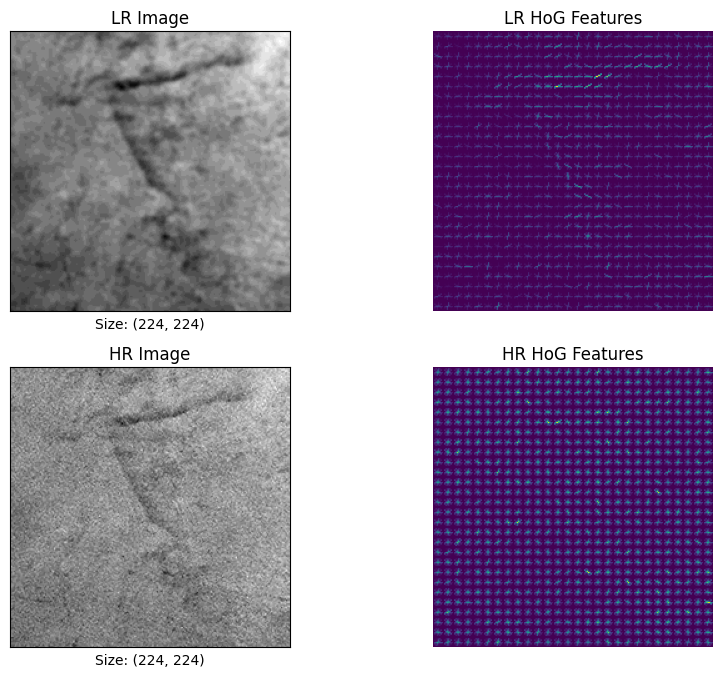

In [26]:
np.random.seed(42)

# Get HoG feature for a random LR and HR image
lr_dir = os.path.join(train_path, "LR")
idx = np.random.randint(0, len(os.listdir(lr_dir)))
lr_path = os.path.join(lr_dir, os.listdir(lr_dir)[idx])
lr_img = Image.open(lr_path).convert('RGB')
# Convert to Grayscale
lr_img = lr_img.convert('L')
# Convert to numpy array
lr_img = np.array(lr_img)
# Get HoG feature and map
lr_hog_features, lr_hog_image = hog_features_extractor(lr_img, display=True)

# Repeat for HR
hr_dir = os.path.join(train_path, "HR")
hr_path = os.path.join(hr_dir, os.listdir(hr_dir)[idx])
hr_img = Image.open(hr_path).convert('RGB')
# Convert to Grayscale
hr_img = hr_img.convert('L')
# Convert to numpy array
hr_img = np.array(hr_img)
# Get HoG feature and map
hr_hog_features, hr_hog_image = hog_features_extractor(hr_img, display=True)

print(f"LR Image: {lr_path}\n")
print(f"HR Image: {hr_path}\n")

# Plot the Images and feature map side by side
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.imshow(lr_img, cmap='gray')
plt.xlabel(f"Size: {lr_img.shape}")
plt.title('LR Image')
plt.xticks([])
plt.yticks([])

plt.subplot(2, 2, 2)
plt.imshow(lr_hog_image)
plt.title('LR HoG Features')
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(hr_img, cmap='gray')
plt.xlabel(f"Size: {hr_img.shape}")
plt.title('HR Image')
plt.xticks([])
plt.yticks([])

plt.subplot(2, 2, 4)
plt.imshow(hr_hog_image)
plt.title('HR HoG Features')
plt.axis('off')
plt.show()

## 4.3 Feature Extraction

In [27]:
from pathlib import Path

def extract_features(img_input, sampling, inf=False):

    '''
    Extract HoG features from the image patches.

    Parameters:
    - img_path (str): The path to the image.
    - sampling (str): The type of sampling to use - 'fixed' or 'random'.
    - inf (bool): If True, only extract HR features.

    Returns:
    - lr_features (list): List of LR image features.
    - hr_features (list): List of HR image features.
    '''

    # Check if the input is of type Posixpath or PIL image/ numpy array
    if isinstance(img_input, Path):
        # Load the image
        try:
            img = Image.open(img_input).convert('L')
            img_name = img_input.stem
        except Exception as e:
            print(f"Error opening image: {e}")
            return
    elif isinstance(img_input, Image.Image):
        img = img_input.convert('L')
        img_name = "def"
    elif isinstance(img_input, np.ndarray):
        img = Image.fromarray(img_input).convert('L')
        img_name = "def"
    else:
        raise ValueError("Invalid image input: must be a file path or image")

    # Get the features from the image patches
    if inf:
        hr_patches = get_patch(img_name, img, num_patches=8, sampling=sampling, save=False, inf=True)
        hr_features = [hog_features_extractor(patch) for patch in hr_patches]
        return hr_features

    # Get the features from LR and HR image patches 
    hr_patches, lr_patches = get_patch(filename=img_name, img=img, num_patches=8, sampling=sampling, save=False)
    lr_features = [hog_features_extractor(patch) for patch in lr_patches]
    hr_features = [hog_features_extractor(patch) for patch in hr_patches]
    return lr_features, hr_features


In [28]:
import os
from pathlib import Path
from PIL import Image
import numpy as np
from tqdm import tqdm
import concurrent.futures
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def _features(img_input: list, sampling: str, types: list, verbose: bool = True, inf=False):
    """
    Process images for feature extraction, handling both training (HR and LR) and inference (HR only).

    Parameters:
    - dir (str): Directory containing the images.
    - sampling (str): Sampling method ('fixed' or 'random').
    - types (list): List of types of features to calculate ('max', 'average', 'norm', 'pca').
    - ext (str): File extension to search for.
    - inf (bool): Whether the function is called during inference or not.

    Returns:
    - X, y: Dictionaries containing features and labels.
    """
    # Initialize feature dictionaries for 'max' and 'average' calculations
    X, y = {type: [] for type in types if type in ["max", "average"]}, {type: [] for type in types if type in ["max", "average"]}

    # Add all features and labels for norm and pca if necessary
    X['all'], y['all'] = [], []

    # img_paths = sorted(Path(dir).glob(ext))
    logging.info(f"Processing {len(img_input)} images...")

    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Map processing based on whether inference mode is active
        if inf and verbose:
            results = list(tqdm(executor.map(lambda p: extract_features(p, sampling, inf=True), img_input), total=len(img_input)))
        elif inf:
            results = list(executor.map(lambda p: extract_features(p, sampling, inf=True), img_input))
        else:
            results = list(tqdm(executor.map(lambda p: extract_features(p, sampling), img_input), total=len(img_input)))

    for features in results:
        if inf:
            # If inference, we have only HR features
            hr_features = features
            for type in types:
                if type == "max":
                    X[type].append(np.max(hr_features, axis=0))
                elif type == "average":
                    X[type].append(np.mean(hr_features, axis=0))
            # y['all'].extend([1] * len(hr_features))  # Label HR as '1'
            X['all'].extend(hr_features)
        else:
            # During training, we handle pairs of LR and HR features
            lr_features, hr_features = features

            for type in types:
                if type == "max":
                    X[type].extend([np.max(f, axis=0) for f in [lr_features, hr_features]])
                    y[type].extend([0, 1])
                elif type == "average":
                    X[type].extend([np.mean(f, axis=0) for f in [lr_features, hr_features]])
                    y[type].extend([0, 1])
            y['all'].extend([0] * len(lr_features) + [1] * len(hr_features))
            X['all'].extend(lr_features)
            X['all'].extend(hr_features)

    logging.info("Feature processing complete.")

    return (X, y) if not inf else X

### 4.3.1 Random Image feature extraction

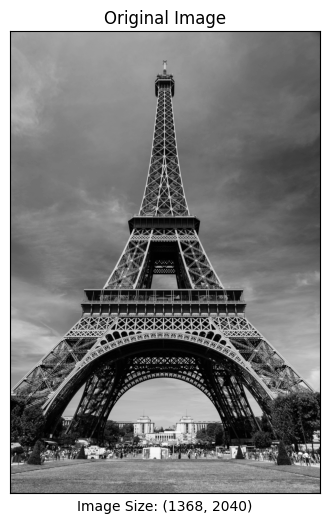

In [29]:
np.random.seed(100)
# Check get_patches function
dir = div2k_train_path
ext = "*.png"
num_patches = 8
sampling = "random"

# Get the image path
img_paths = sorted(Path(dir).glob(ext))

# Get a random idx
idx = np.random.randint(0, len(img_paths))
img_path = img_paths[idx]

# Open the image
img = Image.open(img_path).convert('L')

# Plot the image
plt.figure(figsize=(10, 6))
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.xlabel(f"Image Size: {img.size}")
plt.xticks([])
plt.yticks([])
plt.show()

Number of HR Patches: 8


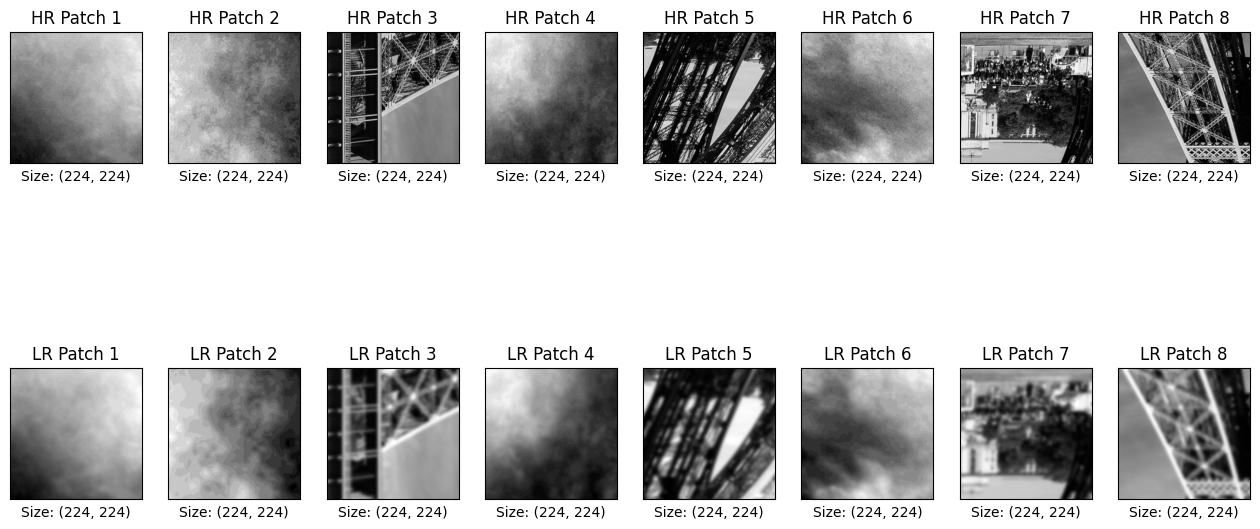

In [30]:
# Get the patches
hr_patches, lr_patches = get_patch(img_path.stem, img, num_patches, sampling, save_hr_path=None, save_lr_path=None, save=False, inf=False)

print(f"Number of HR Patches: {len(hr_patches)}")

# Plot the HR and LR patches side by side
plt.figure(figsize=(16, 8))
for i in range(num_patches):
    plt.subplot(2, num_patches, i + 1)
    plt.imshow(hr_patches[i], cmap='gray')
    plt.xlabel(f"Size: {hr_patches[i].shape}")
    plt.xticks([])
    plt.yticks([])
    plt.title(f"HR Patch {i+1}")

    plt.subplot(2, num_patches, i + num_patches + 1)
    plt.imshow(lr_patches[i], cmap='gray')
    plt.xlabel(f"Size: {lr_patches[i].shape}")
    plt.xticks([])
    plt.yticks([])
    plt.title(f"LR Patch {i+1}")


In [31]:
# Get the aggregated features
X, y = _features([img_path], sampling, types=["max", "average", "norm", "pca"], inf=False)

# Print the shapes of the features
for key, value in X.items():
    print(f"{key}: {len(value)}")
    print(f"Feature Shape: {value[0].shape}")

2024-05-17 00:01:18,336 - INFO - Processing 1 images...
100%|██████████| 1/1 [00:02<00:00,  2.74s/it]
2024-05-17 00:01:21,089 - INFO - Feature processing complete.


max: 2
Feature Shape: (26244,)
average: 2
Feature Shape: (26244,)
all: 16
Feature Shape: (26244,)


### 4.3.2 Random Image feature extraction(Inference)

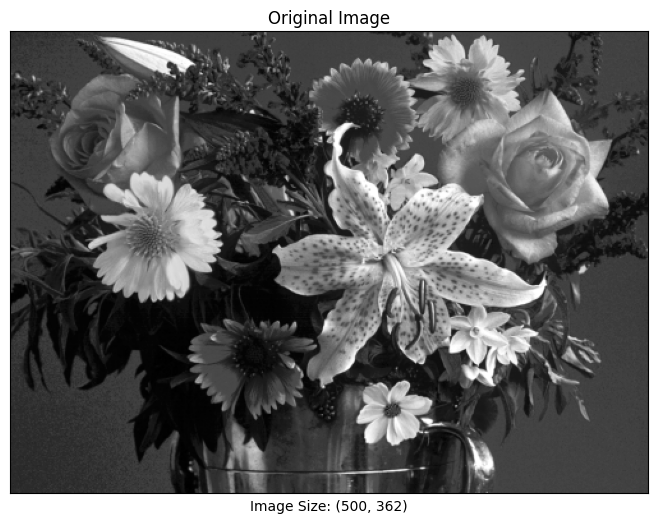

In [32]:
# Get the patches for inference
np.random.seed(10)
# Check get_patches function
dir = testset
ext = "*.bmp"
num_patches = 8
sampling = "random"

# Get the image path
img_paths = sorted(Path(dir).glob(ext))

# Get a random idx
idx = np.random.randint(0, len(img_paths))
img_path = img_paths[idx]

# Open the image
img = Image.open(img_path).convert('L')

# Plot the image
plt.figure(figsize=(10, 6))
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.xlabel(f"Image Size: {img.size}")
plt.xticks([])
plt.yticks([])
plt.show()

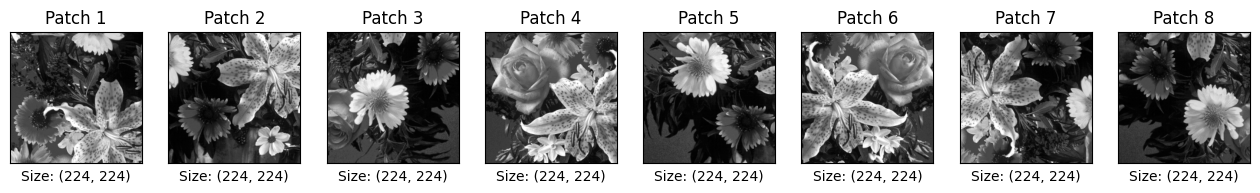

In [33]:
patches = get_patch(img_path.stem, img, num_patches, sampling, save_hr_path=None, save_lr_path=None, save=False, inf=True)

# Plot the patches
plt.figure(figsize=(16, 8))
for i in range(num_patches):
    plt.subplot(1, num_patches, i + 1)
    plt.imshow(patches[i], cmap='gray')
    plt.xlabel(f"Size: {patches[i].shape}")
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Patch {i+1}")

In [34]:
# Get the aggregated features for inference
X = _features([img_path], sampling, types=["max", "average", "norm", "pca"], inf=True)

# Print the shapes of the features
for key, value in X.items():
    print(f"{key}: {len(value)}")
    print(f"Feature Shape: {value[0].shape}")

2024-05-17 00:01:22,338 - INFO - Processing 1 images...
100%|██████████| 1/1 [00:01<00:00,  1.39s/it]
2024-05-17 00:01:23,736 - INFO - Feature processing complete.


max: 1
Feature Shape: (26244,)
average: 1
Feature Shape: (26244,)
all: 8
Feature Shape: (26244,)


## 4.4 Feature Saving

In [35]:
import pickle
import os

def save_features(path:str, X: list, y: list, type: str):

    try:
        # Save features
        features_file_path = f"{path}_{type}_features.pkl"
        with open(features_file_path, 'wb') as file:
            pickle.dump(X, file)

        # Save labels
        labels_file_path = f"{path}_{type}_labels.pkl" 
        with open(labels_file_path, 'wb') as f:
            pickle.dump(y, f)
        
        print(f"Saved Successfully!!!")
    
    except Exception as e:
        print(f"Error: {e}")

    return features_file_path, labels_file_path

## 4.5 Feature Loading

In [36]:
import pickle

def feature_loading(features_file_path:str, labels_file_path:str):
    try:

        # Load training data
        with open(features_file_path, 'rb') as f:
            X = pickle.load(f)

        with open(labels_file_path, 'rb') as f:
            y = pickle.load(f)

        print(f"Successfully Loaded Training Data!!\n")

        return X, y

    except Exception as e:

        print(f"Falied to Load Training Data!!\n")
        print(f"Error: {e}")

# 5.0 Tracking Expirements

In [37]:
# model_dir = f"/home/mayank/Documents/Python/SRCNN_DIV2K/Models/Classifier"
# Ajit-new
model_dir = f"/hard-disk-2/users/mpershad/SRCNN_DIV2K/Models/Classifier"

## 5.1 Config

In [ ]:
config = {
    'architecture': 'SVM',
    'features': 'HoG',
    'dataset': 'DIV2K',
    'feature_params': {
        'sampling': ['fixed', 'random'],
        # 'processing': ["max", "average", "scaler", "pca", "scaler_pca", "max_scaler", "average_scaler", "max_scaler_pca", "average_scaler_pca"]
        'processing': ["max", "average", "max_scaler", "average_scaler", "max_scaler_pca", "average_scaler_pca"]
        # 'processing': ["max_scaler"]
    },
    'params': {
        'C': [100], 
        'kernel': ['rbf'],
        'gamma': ['scale']
    },
    'operation': operation, 
    'scale': scale
}


In [ ]:
model_name = input('Enter Model name: ')
model_path = os.path.join(model_dir, model_name)

In [ ]:
import wandb

# Try to Log in to your W&B account
try:
    wandb.login()
    print("Successfully logged in to W&B!")

    # Initialize a W&B run
    wandb.init(project='SRCNN+VGG', entity='pershadmayank', config=config)

except Exception as e:
    print("Error during login:", e)

## 5.2 Setup

### 5.2.1 Feature extraction

In [ ]:
# # Generate Features 
# from tqdm.notebook import tqdm

# data_config = {}
# ext="*.png"

# # Create the directory to save the model
# if not os.path.exists(model_path):
#     os.makedirs(model_path)

# for sampling in tqdm(config['feature_params']['sampling'], total=len(list(config['feature_params']['sampling']))):

#     # Training Data
#     print(f"Training features!! \n")
#     X_features, y_features = _features(sorted(Path(div2k_train_path).glob(ext)), sampling, config['feature_params']['processing'], inf=False)

#     for key, value in X_features.items():
#         print(f"{key}: {len(value)}")
#         print(f"Feature Shape: {value[0].shape}")

#     # Save the features
#     features_file_path, labels_file_path = save_features(os.path.join(model_path, sampling), X_features, y_features, type="Train")

#     # Save the path to the features and labels for loading later
#     data_config[f'{sampling}_features'] = features_file_path
#     data_config[f'{sampling}_labels'] = labels_file_path
    
#     # Validation Data
#     print(f"Validation features!! \n")
#     X_val_features, y_val_features = _features(sorted(Path(div2k_validation_path).glob(ext)), sampling, config['feature_params']['processing'], inf=False)

#     # Save the features
#     features_file_path, labels_file_path = save_features(os.path.join(model_path, sampling), X_val_features, y_val_features, type="Val")

#     # Save the path to the features and labels for loading later
#     data_config[f'{sampling}_val_features'] = features_file_path
#     data_config[f'{sampling}_val_labels'] = labels_file_path

# # Save the data_config as pickle file
# with open(os.path.join(model_path, f"data_config.pkl"), 'wb') as file:
#     pickle.dump(data_config, file)

### 5.2.2 Setting Up Metrics Data Frame

In [ ]:
import os
import pandas as pd

# Load the overall_results for Storing training result(train_acc, val_acc) for all possible combination of features_params and params
# metrics_path = f'/home/mayank/Documents/Python/SRCNN_DIV2K/Metrics/Classifier'
# Ajit-new
metrics_path =f'/hard-disk-2/users/mpershad/SRCNN_DIV2K/Metrics/Classifier'

# Check if the overall_results csv exists
overall_results_path = os.path.join(metrics_path, f"metrics_{model_name}.csv") 
if os.path.exists(overall_results_path):
    overall_results = pd.read_csv(overall_results_path)
    print(f"File Found and Loaded Successfully!!\n")
else:
    print(f"File Not Found!!\n")
    overall_results = pd.DataFrame()

In [ ]:
# To start training from beginning of the config
samp_idx = 0
type_idx = 0

In [ ]:
# To resume training from the last configuration(Samping the preprocessing)
if not overall_results.empty:
    last_sampling = overall_results.iloc[-1]['sampling']
    last_type = overall_results.iloc[-1]['type']

    print(f"Sampling : {last_sampling}, Type: {last_type}\n")

    # Find the index of the last completed configuration
    samp_idx = config['feature_params']['sampling'].index(last_sampling)
    type_idx = config['feature_params']['processing'].index(last_type)

    # Determining whether to move to the next sampling
    if type_idx + 1 == len(config['feature_params']['processing']):
        samp_idx += 1
        type_idx = 0
    else:
        type_idx += 1
else:
    # Start from the beginning if no results are found
    samp_idx = 0
    type_idx = 0

### 5.2.3 Transformation 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

def preprocessing(model_path, model_type, data, retrain=False):

    if os.path.exists(model_path) and not retrain:
        logging.info(f"{model_type} model loaded from {model_path}")
        return joblib.load(model_path)
    else:
        logging.info(f"Training new {model_type} model.")
        if model_type == "scaler":
            model = StandardScaler()
        elif model_type == "pca":
            model = PCA(n_components=0.95)
        elif model_type == 'pipeline':
            model = Pipeline([
                ('scaler', StandardScaler()),
                ('pca', PCA(n_components=0.95))
            ])
        
        # Log the time to apply the transformation
        logging.info(f"Applying Transformation\n")
        start_time = time.time()
        # Apply standard scaler to all features on training features
        model.fit_transform(data)
        # Logging
        end_time = time.time()
        total_time = (end_time - start_time) 
        logging.info(f"Sucessfully applied in {total_time:.2f}!!\n")
        # Save transform 
        joblib.dump(model, model_path)
        print(f"Transform saved Successfully!!\n")
        return model

### 5.2.4 Data Loading

In [ ]:
def data(features, labels, type, transform=None):

    X, y = features[type], labels[type]

    if transform:
        X = transform.transform(X)
    return X, y

### 5.2.5 Training

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# Load the data_config file
with open(os.path.join(model_path, f"data_config.pkl"), 'rb') as file:
    data_config = pickle.load(file)

model_transform = {}

for i, sampling in enumerate(tqdm(config['feature_params']['sampling'][samp_idx:], total=len(config['feature_params']['sampling'][samp_idx:]))):

    # Load the features
    features, labels = feature_loading(data_config[f"{sampling}_features"], data_config[f"{sampling}_labels"])

    val_features, val_labels = feature_loading(data_config[f"{sampling}_val_features"], data_config[f"{sampling}_val_labels"])

    for j, type in enumerate(tqdm(config['feature_params']['processing'][type_idx:], 
                                           total=len(config['feature_params']['processing'][type_idx:]))):

        if i == 0 and j == 0:
            type_idx = 0  # Reset for subsequent samplings
        
        # Setup basic configuration for logging
        print(f"Sampling: {sampling} | Type: {type}\n")
        logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

        # Get features and labels
        data_type = type

        if "max" in type:
            data_type = "max"
        elif "average" in type:
            data_type = "average"
        elif "max" not in type and "average" not in type:
            data_type = "all"

        X, y = data(features, labels, data_type)
        X_val, y_val = data(val_features, val_labels, data_type)

        # Apply transform
        transform_path = os.path.join(model_path, f"{sampling}_{type}.joblib")
        if type == "max" or type == "average":
            transform = None
            transform_path = ''
        elif type == "scaler" or type == "pca":
            transform = preprocessing(transform_path, type, X)
        else:
            transform = preprocessing(transform_path, "pipeline", X)

        if transform:
            X = transform.transform(X)
            X_val = transform.transform(X_val)
        

        # Get respective features for the type
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        print(f"SVM Training!! \n")
        results = train_parallel(X_train=X_train,
                                y_train=y_train,
                                X_val=X_val,
                                y_val=y_val,
                                process=f"{sampling}_{type}",
                                model_name=model_name,
                                transform_path=transform_path,
                                params=config['params'])
        
        # Append results['model_details'] to model_transform dictionary
        for key, value in results['model_details'].items():
            model_transform[key] = value

        # update overall_results
        params = generate_combinations(config['params'])
        df = pd.DataFrame(params)
        df['sampling'] = sampling
        df['type'] = type
        df['train_acc'] = results['train_acc']
        df['val_acc'] = results['val_acc']
        overall_results = pd.concat([overall_results, df], axis=0)


In [ ]:
# Fix the indexing
overall_results.reset_index(drop=True, inplace=True)
overall_results

In [ ]:
# overall_results = overall_results[1:]
# overall_results

## 5.3 Save result Dictionary

In [ ]:
import pickle
import os

# metrics_path =f'/home/mayank/Documents/Python/SRCNN_DIV2K/Metrics/Classifier'
# Ajit-new
metrics_path =f'/hard-disk-2/users/mpershad/SRCNN_DIV2K/Metrics/Classifier'

if not os.path.exists(metrics_path):
  os.makedirs(metrics_path)

# Save the overall results as csv
overall_results.to_csv(os.path.join(metrics_path, f"metrics_{model_name}.csv"), index=False)

print(f"Results saved!!!\n")

In [ ]:
import pickle
import os

# Save model_transform dictionary
path = os.path.join(model_path, f"model_transform.pkl")

try:
    with open(path, 'wb') as file:
        pickle.dump(model_transform, file)
    print(f"Model and Transform paired saved!!!\n")
except Exception as e:
    print(f"Error: {e}")

# 6.0 Loading Pretrained Model

## 6.1 Load Model, Trasnform and Metrics

In [38]:
model_name = input('Enter Model name: ')
model_path = os.path.join(model_dir, model_name)

In [39]:
# Load the data_config file
with open(os.path.join(model_path, f"data_config.pkl"), 'rb') as file:
    data_config = pickle.load(file)

In [40]:
import pandas as pd

metrics_path =f'/hard-disk-2/users/mpershad/SRCNN_DIV2K/Metrics/Classifier'
overall_results_path = os.path.join(metrics_path, f"metrics_{model_name}.csv") 

# Load the overall_results 
if os.path.exists(overall_results_path):
    overall_results = pd.read_csv(overall_results_path)
    print(f"Results File Found and Loaded Successfully!!\n")
else:
    print(f"Results File Not Found!!\n")


Results File Found and Loaded Successfully!!



In [41]:
# Load the model transform dictionary
model_transform_path = os.path.join(model_path, f"model_transform.pkl")

if os.path.exists(model_transform_path):
    model_transform = pickle.load(open(model_transform_path, 'rb'))
    print(f"Model Transform File Found and Loaded Successfully!!\n")
else:
    print(f"Model Transform File Not Found!!\n")

Model Transform File Found and Loaded Successfully!!



## 6.2 Loading Transformation

In [42]:
import joblib

def load_process(path):
    # Load preprocessing transformer
    if os.path.exists(path):
        preprocess = joblib.load(path)
        print("Preprocessing model loaded successfully.")
        return preprocess
    else:
        raise FileNotFoundError("Preprocessing model not found.")

## 6.3 Loading SVM

In [43]:
import pickle

def load_model(path):

    if os.path.exists(path):
        with open(path, 'rb') as f:
            checkpoint = pickle.load(f)
            model = checkpoint['model']
            param = checkpoint['Parameters']
            print(f"Model loaded successfully!!\n")
            return model, param  
    else:
        raise FileNotFoundError("SVM model not found.")

## 6.4 Loading SVM and corresponding Transformation

In [44]:
import os
import re

def load_model_for_inference(process_path, model_path):
    """
    Load the trained SVM model and its corresponding preprocessing pipeline for inference,
    using regex for detailed filename matching.

    Parameters:
    - sampling_type (str): Type of sampling used during training.
    - feature_type (str): Type of features used during training.
    - model_dir (str): Directory where trained SVM models are stored.
    - preprocess_dir (str): Directory where preprocessing models are stored.

    Returns:
    - predict_function: A function that takes raw data and returns predictions.
    """


    preprocess = None
    # Check is process_path is not empty string
    if process_path:
        print(f"Preprocess: {process_path}")
        # Load preprocessing model
        preprocess = load_process(process_path)

    # Load SVM model and its parameters
    model, params = load_model(model_path)
    print(f"SVM model loaded with parameters: {params}")

    return model, preprocess 

## 6.5 Prediction Function

In [45]:
# Define a prediction function that applies preprocessing and model prediction
def predict_function(features_list, preprocess, svm_model):
    """
    Apply preprocessing transformation, predict using the SVM model, and get distances from the decision boundary.

    Parameters:
    - features_list (list): List of features to be processed.
    - preprocess (transformer): The preprocessing model (e.g., StandardScaler, PCA).
    - svm_model (model): The trained SVM model.

    Returns:
    - predictions: Predicted class labels for the input features.
    - distances: Distances from the decision boundary for the input features.
    """
    X_transformed = features_list
    # Transform the features
    if preprocess:
        X_transformed = preprocess.transform(features_list)

    # Get predictions
    predictions = svm_model.predict(X_transformed)

    # Get distances from the decision boundary
    distances = svm_model.decision_function(X_transformed)

    return X_transformed, predictions, distances

# 7.0 Features

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 7.1 Loading Pretrained SR N/W

In [117]:
# Replace with the run ID you want to download from
# run_id = input("Enter runtime ID: ")
run_id = "1qyo082m"

In [118]:
# Replace with the artifact name
# artifact = input("Enter artifact name: ")
artifact = "pershadmayank/SRCNN+VGG/SRCNN:v2"

In [119]:
model = SRCNN.load_model_from_wandb(run_id=run_id,
                                    artifact_id=artifact,
                                    device=device).to(device)

model

wandb:   1 of 1 files downloaded.  


SRCNN(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(9, 9), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 3, kernel_size=(5, 5), stride=(1, 1), padding=same)
  )
)

## 7.2 Prediction Using SR N/W

In [50]:
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2 as cv

def pred_and_plot_image(model: torch.nn.Module, image_path: str, lr_image, lr_image_args, transform=None, plot=False, device: torch.device = torch.device('cpu')):
 
  # Load image and convert to RGB
  img = Image.open(image_path).convert('RGB')
  img = np.array(img)

  # Generate Low Resolution Image
  lr_img = lr_image(img, **lr_image_args) 

  # Convert the RGB image to a PyTorch tensor
  if transform:
    img_tensor = transform(lr_img)
  else:
    # Create a transform
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    img_tensor = transform(lr_img)
  
  # Move the tensor to the designated device
  img_tensor = img_tensor.to(device)

  # Set model to evaluation mode
  model.eval()
  with torch.inference_mode():
    img_predicted = model(img_tensor.unsqueeze(dim=0).to(device))

  # Move the predicted image to the CPU
  img_predicted = img_predicted.cpu().squeeze()

  # Rearrange the channels
  img_predicted = img_predicted.permute(1, 2, 0)

  # Convert to numpy array
  img_predicted = img_predicted.numpy() * 255
  
  # Convert to uint8
  img_predicted = img_predicted.astype(np.uint8)

  if plot:
    # Calculate the combined metrics b/w original and predicted image
    metrics = combined_metric(img, img_predicted)
    metrics_str = f"MSE: {metrics[0]:.2f}\n PSNR: {metrics[1]:.2f} dB\n SSIM: {metrics[2]:.2f}\n"

    # Calculate the combined metrics b/w original and LR image
    metrics_lr = combined_metric(img, lr_img)
    metrics_str_lr = f"MSE: {metrics_lr[0]:.2f}\n PSNR: {metrics_lr[1]:.2f} dB\n SSIM: {metrics_lr[2]:.2f}\n"

    plt.figure(figsize=(12, 10))

    # Plot the LR Image
    plt.subplot(1, 3, 1)
    plt.imshow(lr_img)
    plt.title("LR Image")
    plt.xlabel(metrics_str_lr)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 3, 2)
    plt.imshow(img)
    plt.title("Original HR Image")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 3, 3)
    plt.imshow(img_predicted)
    plt.title("Predicted Image")
    plt.xlabel(metrics_str)
    plt.xticks([])
    plt.yticks([])
    plt.show()
  return lr_img, img, img_predicted

In [51]:
# /content/SRCNN/Data/Test/LR/lenna.bmp
# test_img_path = input("Enter Image Path: ")
test_img_path = "/hard-disk-2/users/mpershad/TestSet/lenna.bmp"

In [52]:
# Parameters for generate_lr_image
lr_image_args = {
    'operation': operation,
    'scale': scale,
    'kernel_size': kernel_size,
    'sigma': sigma
}

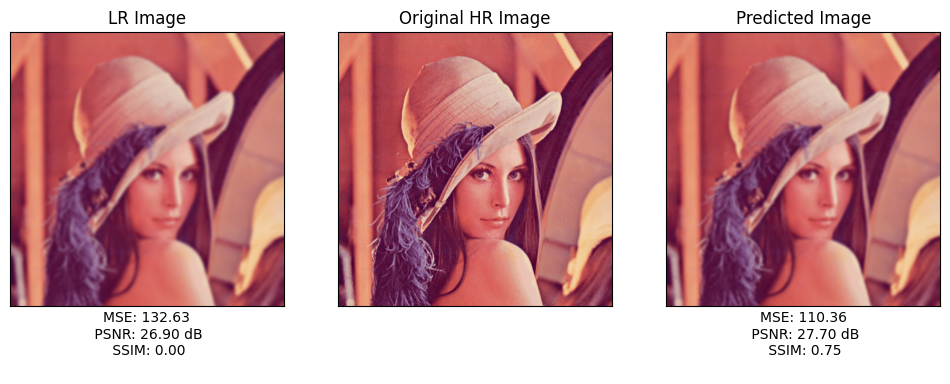

In [53]:
lr_img, img, pred_img = pred_and_plot_image(model=model,  # Replace with your model variable
                                image_path=test_img_path,  # Replace with the path to your image
                                lr_image=generate_lr_image,  # The function to generate LR image
                                lr_image_args=lr_image_args,  # Arguments for the LR image function
                                device=device,  # The device (cpu or cuda)
                                plot=True)

In [ ]:
import pandas as pd
import os
from PIL import Image
from torchvision import transforms
from tqdm.notebook import tqdm

# Create dictionary to store the metrics
metrics_dict = {'Filename': [], 'PSNR': [], 'SSIM': []}

X_test_max = []
X_test_avg = []
y_test_classes = []
y_test = []

test_img_dir = "/hard-disk-2/users/mpershad/TestSet"
for f in tqdm(os.listdir(test_img_dir)):
    
    img_path = os.path.join(test_img_dir, f)

    # Get the filename
    filename = f.split('.')[0]

    lr_img, img, pred_img = pred_and_plot_image(model=model,  # Replace with your model variable
                                    image_path=img_path,  # Replace with the path to your image
                                    lr_image=generate_lr_image,  # The function to generate LR image
                                    lr_image_args=lr_image_args,  # Arguments for the LR image function
                                    device=device,  # The device (cpu or cuda)
                                    plot=False)
    
    # Get the metrics
    metrics = combined_metric(img, pred_img)

    # Get features for LR, HR and Predicted image and append to X_test and y_test
    features = _features([lr_img, img, pred_img], sampling, ["max", "average"], verbose = False, inf = True)

    X_test_max.extend(features["max"])
    X_test_avg.extend(features["average"])
    y_test_classes.extend([0, 1, 2])
    y_test.extend([0, 1, 1])

    # Update the dictionary
    metrics_dict['Filename'].append(filename)
    metrics_dict['PSNR'].append(metrics[1])
    metrics_dict['SSIM'].append(metrics[2])

results_df = pd.DataFrame(metrics_dict)

## 7.3 TSNE Plot 

In [55]:
from matplotlib.lines import Line2D
from sklearn.manifold import TSNE

def TSNE_plot(features, features_transformed, y_test_classes):

    # Convert to numpy array
    features = np.array(features)
    features_transformed = np.array(features_transformed)

    # Apply TSNE
    tsne = TSNE(n_components=2, random_state=100)
    tsne_features = tsne.fit_transform(features)

    tsne_features_transformed = tsne.fit_transform(features_transformed)
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    colors = ['blue', 'green', 'red']
    category_labels = ['LR', 'HR', 'SR']

    legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10, label=l)
                    for c, l in zip(colors, category_labels)]

    # Scatter plot with labels for features
    for i, label in enumerate(y_test_classes):  # Assuming y_train has 0 for LR, 1 for HR
        x, y = tsne_features[i]
        plt.scatter(x, y, c=colors[label])
        plt.text(x, y, str(i // 3 + 1), fontsize=8, ha='right', va='bottom')

    plt.title('LR, HR and SR Image HoG Features', fontsize=12)
    plt.xlabel('TSNE Dimension 1')
    plt.ylabel('TSNE Dimension 2')
    plt.legend(handles=legend_handles, title="Categories")

    plt.subplot(1, 2, 2)
    for i, label in enumerate(y_test_classes):  # Assuming y_train has 0 for LR, 1 for HR
        x, y = tsne_features_transformed[i]
        plt.scatter(x, y, c=colors[label])
        plt.text(x, y, str(i // 3 + 1), fontsize=8, ha='right', va='bottom')

    plt.title('LR, HR and SR Image Transformed HoG Features', fontsize=12)
    plt.xlabel('TSNE Dimension 1')
    plt.ylabel('TSNE Dimension 2')
    plt.legend(handles=legend_handles, title="Categories")
    plt.show()


## 7.4 SVM Kernel Plot

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap

def TSNE_SVM_plot(features, y_test_classes):
    # Convert to numpy array
    features = np.array(features)

    # Apply TSNE
    tsne = TSNE(n_components=2, random_state=100)
    tsne_features = tsne.fit_transform(features)
    
    # Train SVM on the t-SNE features
    svm = SVC(kernel='rbf', random_state=100)
    svm.fit(tsne_features, y_test_classes)
    
    # Create mesh to plot in
    x_min, x_max = tsne_features[:, 0].min() - 1, tsne_features[:, 0].max() + 1
    y_min, y_max = tsne_features[:, 1].min() - 1, tsne_features[:, 1].max() + 1
    h = 0.02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Print the shapes to check
    print("Shape of xx: ", xx.shape)
    print("Shape of yy: ", yy.shape)
    
    # Predict the decision function on a grid
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    print("Total grid points: ", grid_points.shape)
    Z = svm.predict(grid_points)
    print("Total predictions: ", Z.size)

    # Reshape prediction back into the grid shape
    Z = Z.reshape(xx.shape)
    
    # Put the result into a color plot
    plt.figure(figsize=(12, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=ListedColormap(['blue', 'green', 'red']))

    # Plot also the training points
    colors = ['blue', 'green', 'red']
    for i, label in enumerate(y_test_classes):
        plt.scatter(tsne_features[i, 0], tsne_features[i, 1], c=colors[label], edgecolors='k', s=60)

    plt.title('Decision Boundary with t-SNE Features')
    plt.xlabel('TSNE Dimension 1')
    plt.ylabel('TSNE Dimension 2')
    plt.show()

# 8.0 Inference

In [57]:
overall_results.tail(5)

,C,kernel,gamma,sampling,type,train_acc,val_acc
7,100,rbf,scale,random,average,0.968750,0.945
8,100,rbf,scale,random,max_scaler,0.949219,0.920
9,100,rbf,scale,random,average_scaler,0.988281,0.825
10,100,rbf,scale,random,max_scaler_pca,0.960938,0.910
11,100,rbf,scale,random,average_scaler_pca,0.972656,0.825


In [58]:
# Get the index of a model
idx = 8
sampling = overall_results.iloc[idx]['sampling']
type = overall_results.iloc[idx]['type']
C = overall_results.iloc[idx]['C']
kernel = overall_results.iloc[idx]['kernel']
gamma = overall_results.iloc[idx]['gamma']

# Construct the model name to be loaded
model_name = f"{sampling}_{type}_C_{C}_kernel_{kernel}_gamma_{gamma}"

# Load the best model
model_path = model_transform[model_name]['model_path']
process_path = model_transform[model_name]['process']

# Print the model details
print(f"Type: {type} | Sampling: {sampling} | C: {C} | Kernel: {kernel} | Gamma: {gamma}\n")
# Load the model and corresponding transform(if exists) for inference
model, preprocess = load_model_for_inference(process_path, model_path)

Type: max_scaler | Sampling: random | C: 100 | Kernel: rbf | Gamma: scale

Preprocess: /hard-disk-2/users/mpershad/SRCNN_DIV2K/Models/Classifier/svm2/random_max_scaler.joblib
Preprocessing model loaded successfully.
Model loaded successfully!!

SVM model loaded with parameters: {'C': 100, 'kernel': 'rbf', 'gamma': 'scale'}


In [59]:
# Get feature type max, average
feature_type = type.split("_")[0]

# Do prediction
if feature_type == "max":
    X_transformed, pred_labels, distances = predict_function(X_test_max, preprocess, model)
elif feature_type == "average":
    X_transformed, pred_labels, distances = predict_function(X_test_avg, preprocess, model)

In [60]:
# Calculate accuracy using y_test and pred_lables
accuracy = accuracy_score(y_test, pred_labels)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.86


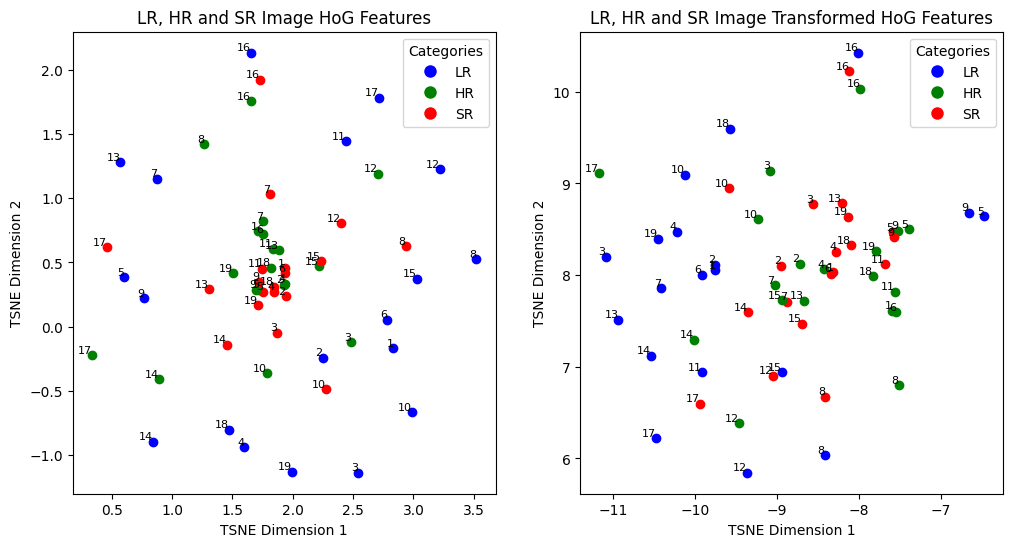

In [61]:
if feature_type == "max":
    TSNE_plot(X_test_max, X_transformed, y_test_classes)
elif feature_type == "average":
    TSNE_plot(X_test_avg, X_transformed, y_test_classes)
else:
    print("No features to plot!!")

Shape of xx:  (330, 335)
Shape of yy:  (330, 335)
Total grid points:  (110550, 2)
Total predictions:  110550


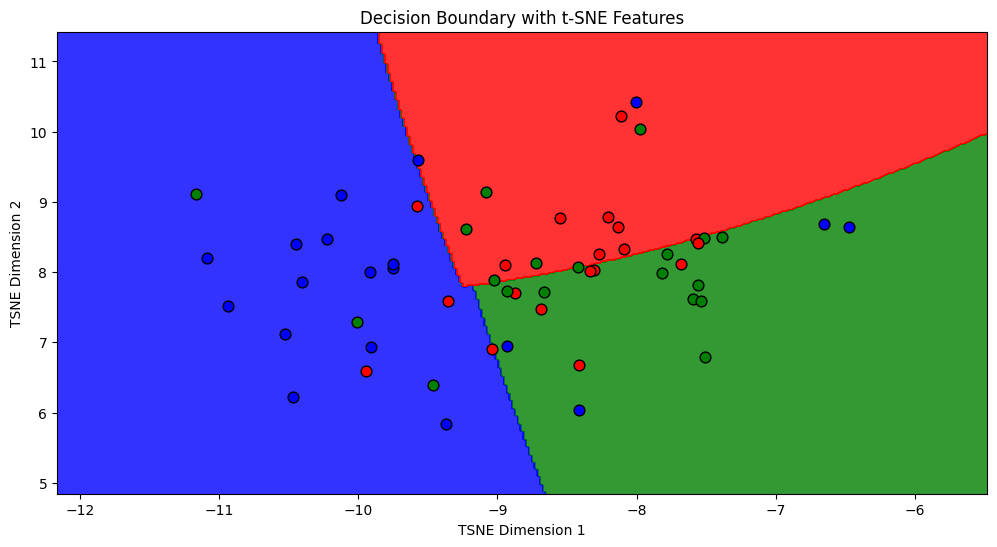

In [62]:
TSNE_SVM_plot(X_transformed, y_test_classes)

# 9.0 Unpaired Dataset 

## 9.1 Custom Dataset for Unapaired LR Images

In [63]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import cv2 as cv
import numpy as np
from typing import Tuple

class UnpairedLRDataset(Dataset):
    def __init__(self, image_paths, operation: str, kernel_size: Tuple[int, int], sigma_color: float = 1.5, sigma_space: float = 1.5, transform=None):
        self.image_paths = image_paths
        self.operation = operation
        self.kernel_size = kernel_size
        self.sigma_color = sigma_color
        self.sigma_space = sigma_space
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB') 

        # Generate unpaired LR image
        lr_image = self.generate_unpaired_lr_image(image)

        if self.transform:
            lr_image = self.transform(lr_image)
        return lr_image

    def generate_unpaired_lr_image(self, image):
        """
        Processes the image based on the specified operation: Bilateral Blur, Box Blur, or Median Blur.

        Parameters:
        - image (np.ndarray): The input image to process. Can be grayscale or color.
        - operation (str): The operation to perform - 'bilateral', 'box', 'median'.
        - kernel_size (Tuple[int, int]): The kernel size for blurring. For median blur, only kernel_size[0] is used.
        - sigma_color (float): The sigma value for color space in bilateral filter.
        - sigma_space (float): The sigma value for coordinate space in bilateral filter.

        Returns:
        - np.ndarray: Low-resolution image.
        """

        if isinstance(image, Image.Image):
            image = np.array(image)

        if self.operation == 'bilateral':
            d = self.kernel_size[0]  # Diameter of each pixel neighborhood.
            lr_image = cv.bilateralFilter(image, d, self.sigma_color, self.sigma_space)
        elif self.operation == 'box':
            lr_image = cv.blur(image, self.kernel_size)
        elif self.operation == 'median':
            ksize = self.kernel_size[0] if self.kernel_size[0] % 2 == 1 else self.kernel_size[0] + 1
            lr_image = cv.medianBlur(image, ksize)
        else:
            raise ValueError("Unsupported operation specified. Choose 'bilateral', 'box', or 'median'.")
        return Image.fromarray(lr_image) 


### 9.1.1 LR Transform

In [64]:
# Hyperparameters for Blurring(Gaussian, Bilateral, Box and Median)
kernel_size = (9, 9)

In [65]:
# Parameters for generate_lr_image
unpaired_lr_args = {
    'operation': 'box',
    'kernel_size': kernel_size,
}

In [66]:
from torchvision import transforms

# LR Image transform(ToTensor, Normalize, RandomHorizontalFlip, Rotate)
lr_train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

lr_val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

### 9.1.2 LR Dataset

In [67]:
# LR Training dataset
unpaired_train_dir = "/hard-disk-2/users/mpershad/T91"
unpaired_train_paths = sorted(Path(unpaired_train_dir).glob("*.bmp"))

# LR Validation dataset
unpaired_val_dir = "/hard-disk-2/users/mpershad/TestSet"
unpaired_val_paths = sorted(Path(unpaired_val_dir).glob("*.bmp"))

# Create LR Train and Validation Dataset
unpaired_train_dataset = UnpairedLRDataset(unpaired_train_paths, **unpaired_lr_args, transform=lr_train_transform)
unpaired_val_dataset = UnpairedLRDataset(unpaired_val_paths, **unpaired_lr_args, transform=lr_val_transform)

unpaired_train_dataset, unpaired_val_dataset

(<__main__.UnpairedLRDataset at 0x7f32c4573820>,
 <__main__.UnpairedLRDataset at 0x7f32c457c9a0>)

### 9.1.3 Turn Custom Dataset into DataLoader

In [68]:
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 32

# Create Dataloade for LR dataset
unpaired_train_dataloader = DataLoader(dataset=unpaired_train_dataset,
                                                 num_workers=os.cpu_count(),
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True)

unpaired_val_dataloader = DataLoader(dataset=unpaired_val_dataset,
                                                     num_workers=os.cpu_count(),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=False)

len(unpaired_train_dataloader), len(unpaired_val_dataloader)

(3, 1)

In [69]:
img_batch = next(iter(unpaired_train_dataloader))

# print out shape
print(f"Image Batch shape: {img_batch.shape} ->[batch_size, color_channel, height, width]")

Image Batch shape: torch.Size([32, 3, 256, 256]) ->[batch_size, color_channel, height, width]


In [70]:
img_batch = next(iter(unpaired_val_dataloader))

# print the shape
print(f"Image Batch shape: {img_batch.shape} ->[batch_size, color_channel, height, width]")

Image Batch shape: torch.Size([19, 3, 256, 256]) ->[batch_size, color_channel, height, width]


## 9.2 Average HR SVM Distance

In [71]:
def compute_average_hr_svm_score(overall_results, model_transform, data_config):
    # Get the index of the best model based on the validation accuracy
    idx = overall_results['val_acc'].idxmax()
    type = overall_results.iloc[idx]['type']
    sampling = overall_results.iloc[idx]['sampling']
    C = overall_results.iloc[idx]['C']
    kernel = overall_results.iloc[idx]['kernel']
    gamma = overall_results.iloc[idx]['gamma']

    # Construct the model name to be loaded
    model_name = f"{sampling}_{type}_C_{C}_kernel_{kernel}_gamma_{gamma}"

    # Load the best model
    model_path = model_transform[model_name]['model_path']
    process_path = model_transform[model_name]['process']

    # Print the model details
    print(f"Type: {type} | Sampling: {sampling} | C: {C} | Kernel: {kernel} | Gamma: {gamma}\n")
    
    # Load the model and corresponding transform (if exists) for inference
    model, preprocess = load_model_for_inference(process_path, model_path)

    # Load the features
    features, labels = feature_loading(data_config[f"{sampling}_features"], data_config[f"{sampling}_labels"])

    # Determine the data type for feature extraction
    if "max" in type:
        data_type = "max"
    elif "average" in type:
        data_type = "average"
    else:
        data_type = "all"

    # Get the features and labels based on the data type
    X, y = features[data_type], labels[data_type]

    # Take every 2nd feature starting from 1st index from X and y
    X = X[1::2]
    y = y[1::2]
    
    X_transformed, pred_labels, distances = predict_function(X, preprocess, model)
    # compute average HR SVM distance
    hr_avg_distance = np.mean(np.abs(distances))
    return model, preprocess, hr_avg_distance


In [72]:
# Compute and save the average HR SVM score
svm_model, preprocess, average_hr_svm_score = compute_average_hr_svm_score(overall_results, model_transform, data_config)

Type: average | Sampling: random | C: 100 | Kernel: rbf | Gamma: scale

Model loaded successfully!!

SVM model loaded with parameters: {'C': 100, 'kernel': 'rbf', 'gamma': 'scale'}
Successfully Loaded Training Data!!



## 9.3 Custom Loss

In [105]:
import torch
import torch.nn as nn
import numpy as np
from skimage.color import rgb2gray
from skimage.feature import hog

class CustomLoss(nn.Module):
    def __init__(self, svm_model, preprocess, average_hr_svm_score, weight_svm=1.0, patch_size=224, num_patches=8, sampling='random'):
        super(CustomLoss, self).__init__()
        self.svm_model = svm_model
        self.preprocess = preprocess
        self.average_hr_svm_score = average_hr_svm_score
        self.weight_svm = weight_svm
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.sampling = sampling

    def forward(self, sr_images):
        batch_size = sr_images.size(0)
        batch_loss = 0.0  # Initialize as a float

        for i in range(batch_size):
            sr_image = sr_images[i]

            # Extract patches from the SR image
            sr_patches = self._get_patch(sr_image, patch_size=self.patch_size, num_patches=self.num_patches, sampling=self.sampling)
            
            # Convert patches to grayscale and extract HOG features
            sr_hog_features = [hog_features_extractor(rgb2gray(patch)) for patch in sr_patches]

            # Aggregate HOG features
            max_features = np.max(sr_hog_features, axis=0).reshape(1, -1)  # Ensure 2D shape
            avg_features = np.mean(sr_hog_features, axis=0).reshape(1, -1)  # Ensure 2D shape

            # Apply preprocessing
            if self.preprocess:
                max_features = self.preprocess.transform(max_features)
                avg_features = self.preprocess.transform(avg_features)

            # Convert to PyTorch tensors
            max_features = torch.tensor(max_features, device=sr_images.device, dtype=torch.float32)
            avg_features = torch.tensor(avg_features, device=sr_images.device, dtype=torch.float32)

            # Compute the SVM decision score for the aggregated features
            svm_score_max = torch.tensor(self.svm_model.decision_function(max_features.cpu().numpy()), device=sr_images.device)
            svm_score_avg = torch.tensor(self.svm_model.decision_function(avg_features.cpu().numpy()), device=sr_images.device)

            # Compute the SVM score loss
            svm_loss_max = (svm_score_max - self.average_hr_svm_score) ** 2
            svm_loss_avg = (svm_score_avg - self.average_hr_svm_score) ** 2

            # Combine the SVM score losses for the current image
            total_loss = self.weight_svm * (svm_loss_max + svm_loss_avg) / 2

            # Accumulate the loss for the batch
            batch_loss += total_loss.item()

        # Average the loss across the batch
        batch_loss /= batch_size

        # Convert the batch_loss to a tensor and ensure it requires gradients
        batch_loss = torch.tensor(batch_loss, device=sr_images.device, requires_grad=True)

        return batch_loss

    def _get_patch(self, image, patch_size=224, num_patches=8, sampling='random'):
        """
        Extract random or fixed patches from the image.
        """
        # Convert the PyTorch tensor to a NumPy array
        image = image.detach().cpu().numpy()
        
        # Transpose the dimensions from (C, H, W) to (H, W, C)
        image = np.transpose(image, (1, 2, 0))
        
        h, w = image.shape[:2]
        patches = []

        for _ in range(num_patches):
            if sampling == 'random':
                ix = np.random.randint(0, w - patch_size)
                iy = np.random.randint(0, h - patch_size)
            elif sampling == 'fixed':
                ix = _ % (w // patch_size) * patch_size
                iy = _ // (w // patch_size) * patch_size
            patches.append(image[iy: iy + patch_size, ix: ix + patch_size])
        
        return patches

# Instantiate the custom loss function with the trained SVM model and average HR SVM score
criterion = CustomLoss(svm_model, preprocess, average_hr_svm_score)

# 10.0 Fine Tuning

## 10.1 `train_Step()`

In [100]:
from typing import Tuple
import torch

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn,
               optimizer: torch.optim.Optimizer,
               device: str,
               max_pixel_value: float = 1.0) -> Tuple[float, float]:
  """
  Performs a single training step including forward pass, loss computation,
  backpropagation, and optimizer step.

  Parameters:
  - model (torch.nn.Module): The neural network model to be trained.
  - dataloader (torch.utils.data.DataLoader): DataLoader for the dataset.
  - loss_fn: Loss function used for training.
  - optimizer (torch.optim.Optimizer): Optimizer used for parameter updates.
  - device (str): Device to run the training on ('cuda' or 'cpu').
  - max_pixel_value (float, optional): The maximum pixel value used in the PSNR calculation. Default is 1.0.

  Returns:
  - train_loss (float): Average training loss for this step.
  - train_psnr (float): Average Peak Signal-to-Noise Ratio (PSNR) for this step.

  Raises:
  - ValueError: If `device` is not 'cuda' or 'cpu'.
  - TypeError: If the provided model, dataloader, loss function, or optimizer are of the wrong type.
  """
  # Ensure model is on the correct device
  model.to(device)

  # Put the model in train mode
  model.train()

  # Setup train loss and PSNR
  train_loss = 0.0
  train_psnr = 0.0

  # Loop through batches of data
  for _, X in enumerate(dataloader):

    X = X.to(device)

    # Forward pass
    y_pred = model(X)

    # Calculate loss
    loss = loss_fn(y_pred)
    train_loss += loss.item()

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Calculate and accumulate PSNR
    mse_loss = nn.functional.mse_loss(y_pred, X, reduction='mean')  # Just for PSNR calculation
    psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(mse_loss))
    train_psnr += psnr.item()

  # Adjust metrics to get average loss and PSNR per batch
  train_loss /= len(dataloader)
  train_psnr /= len(dataloader)

  return train_loss, train_psnr


## 10.2 `validation_step()`

In [101]:
from typing import Tuple
import torch

def validation_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn,
              device: str,
              max_pixel_value: float = 1.0) -> Tuple[float, float]:
  """
  Performs a single evaluation step, calculating the average loss and PSNR
  over the provided dataloader.

  Parameters:
  - model (torch.nn.Module): The neural network model to be evaluated.
  - dataloader (torch.utils.data.DataLoader): DataLoader for the dataset to evaluate.
  - loss_fn: The loss function used for evaluation.
  - device (str): The device to run the evaluation on ('cuda' or 'cpu').
  - max_pixel_value (float, optional): The maximum pixel value used in the PSNR calculation. Default is 1.0.

  Returns:
  - test_loss (float): The average loss over the dataloader.
  - test_psnr (float): The average Peak Signal-to-Noise Ratio over the dataloader.

  Raises:
  - ValueError: If `device` is not 'cuda' or 'cpu'.
  - TypeError: If the provided model, dataloader, loss function, or device are of the wrong type.
  """

  # Ensure model is on the correct device
  model.to(device)

  # Put the model in eval mode
  model.eval()

  test_loss = 0.0
  test_psnr = 0.0

  with torch.inference_mode():
    for _, X in enumerate(dataloader):

      X = X.to(device)

      # Forward pass
      test_pred = model(X)

      # Calculate loss
      loss = loss_fn(test_pred)
      test_loss += loss.item()

      # Calculate and accumulate PSNR
      mse_loss = nn.functional.mse_loss(test_pred, X)  # Just for PSNR calculation
      psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(mse_loss))
      test_psnr += psnr.item()

  # Compute average loss and PSNR
  test_loss /= len(dataloader)
  test_psnr /= len(dataloader)

  return test_loss, test_psnr


## 10.3 Checkpoint Saving Function

In [76]:
import torch
import os

def save_checkpoint_sr(epoch, model, optimizer, loss, path="checkpoint.pth"):
  """
  Saves a checkpoint of the model and optimizer state.

  Parameters:
  - epoch: The current epoch number.
  - model: The model being trained.
  - optimizer: The optimizer being used for training.
  - loss: The loss value at the checkpoint.
  - path: The path to save the checkpoint to.
  """
  checkpoint = {
    'epoch': epoch + 1,  # Saving such that training can resume from the next epoch
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
  }
  torch.save(checkpoint, path)
  print(f"Checkpoint saved at '{path}'")

In [77]:
import os
import shutil

def delete_checkpoints(directory):
    """
    Deletes all files within the specified directory.

    Parameters:
    - directory: The path to the directory whose files are to be deleted.
    """
    # Check if the directory exists
    if os.path.exists(directory):
        # Iterate through all files in the directory
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)
            try:
                # If it is a file, delete it
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                # If it is a directory, delete it and all its contents
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f'Failed to delete {file_path}. Reason: {e}')
        print(f"All checkpoints in '{directory}' have been deleted.")
    else:
        print(f"The directory {directory} does not exist.")

## 10.4 Early Stopping and Best Model Saving

In [78]:
class EarlyStopping:

  def __init__(self, patience=7, verbose=False, delta=0, path='best_model.pth'):
    self.patience = patience
    self.verbose = verbose
    self.delta = delta
    self.best_score = None
    self.early_stop = False
    self.val_loss_min = np.Inf
    self.counter = 0
    self.path = path

  def __call__(self, val_loss, model, optimizer):
    score = -val_loss

    if self.best_score is None:
      self.best_score = score
      self.save_checkpoint(val_loss, model, optimizer)
    elif score < self.best_score + self.delta:
      self.counter += 1
      if self.verbose:
          print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
      if self.counter >= self.patience:
          self.early_stop = True
    else:
      self.best_score = score
      self.save_checkpoint(val_loss, model, optimizer)
      self.counter = 0

  def save_checkpoint(self, val_loss, model, optimizer):
    '''Saves model when validation loss decrease.'''
    if self.verbose:
      print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': val_loss,
    }, self.path)
    self.val_loss_min = val_loss

## 10.5 SRCNN `train()` 

In [122]:
import os
import time
import wandb
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          valid_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn,
          model_name: str,
          start_epoch: int = 0,
          end_epoch: int = 200,
          checkpoint_interval=20,
          device: str = device):

  # 1.0 Start the timer
  start_time = time.time()

  # 2.0 Create a empty result dicitonary
  results = {'train_loss': [], 'val_loss': [], 'train_psnr': [], 'val_psnr': []}

  # 3.0 Directory to save the model
  model_dir = "/hard-disk-2/users/mpershad/SRCNN_DIV2K/Models/SRCNN"
  if not (os.path.exists(model_dir)):
    os.makedirs(model_dir)

  model_path = os.path.join(model_dir, f"{model_name}.pth")

  # 4.0 Calculate Logging Interval(10% of total epochs)
  total_epochs = end_epoch - start_epoch
  log_interval = total_epochs // 10 if total_epochs // 10 > 0 else 1
  
  # 5.0 Initialize the early stopping
  early_stopper = EarlyStopping(patience=int(total_epochs/5), verbose=True, delta=5e-6, path=model_path)

  # --- Signal handling for KeyboardInterrupt ---
  def signal_handler(sig, frame):
    print("KeyboardInterrupt. Saving model and optimizer state.")
    checkpoint_path = f"{model_path}/interrupted.pth"
    save_checkpoint_sr(epoch, model, optimizer, val_loss, path=checkpoint_path)
    print(f"Checkpoint saved. Safetly terminating the training.")

  # Register the signal handler
  signal.signal(signal.SIGINT, signal_handler)
  
  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(start_epoch, end_epoch), total=total_epochs, desc="Epochs"):

    # 6.0 Training step
    train_loss, train_psnr = train_step(model=model,
                            dataloader=train_dataloader,
                            loss_fn=loss_fn,
                            optimizer=optimizer,
                            device=device)

    # 7.0 Testing step(validation)
    val_loss, val_psnr = validation_step(model=model,
                          dataloader=valid_dataloader,
                          loss_fn=loss_fn,
                          device=device)

    # 8.0 Update results dictionary
    results["train_loss"].append(train_loss)
    results["val_loss"].append(val_loss)
    results["train_psnr"].append(train_psnr)
    results["val_psnr"].append(val_psnr)

    # Log PSNR values
    if wandb.log:
      wandb.log({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss, 'train_psnr': train_psnr, 'val_psnr': val_psnr})

    # Log values every 10% of the total epochs
    if epoch % log_interval == 0 or epoch == end_epoch - 1:
      # Print out what's happening
      print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | val_loss: {val_loss:.4f} | train_psnr: {train_psnr:.2f} dB | val_psnr: {val_psnr:.2f} dB")

    # 9.0 Early stopping
    early_stopper(val_loss, model, optimizer)
    if early_stopper.early_stop:
        print("Early stopping")
        break
    
    checkpoint_dir = os.path.join("/hard-disk-2/users/mpershad/SRCNN_DIV2K/Checkpoints/SRCNN", f"{model_name}")
    # Create the directory for saving Checkpoints
    if not (os.path.exists(checkpoint_dir)):
      os.makedirs(checkpoint_dir)

    # 10.0 Checkpoint Saving
    if epoch % checkpoint_interval == 0 or epoch == end_epoch - 1:
      checkpoint_path = os.path.join(checkpoint_dir, f"epoch_{epoch}.pth")
      save_checkpoint_sr(epoch=epoch, model=model, optimizer=optimizer, loss=val_loss, path=checkpoint_path)
      # Optionally log checkpoint to wandb
      if wandb.run:
        wandb.save(checkpoint_path, base_path=checkpoint_dir)

  # 11.0 Use wandb.save() to ensure the model file is saved to W&B
  if wandb.run:
    wandb.save(model_path, base_path=model_dir)

    # 12.0 Log the model as an artifact
    artifact = wandb.Artifact('SRCNN', type='model', description="A super-resolution model with Perpetual loss")
    artifact.add_file(model_path)
    wandb.log_artifact(artifact)

  # 13.0 Calculate and log training duration
  end_time = time.time()
  total_training_time = end_time - start_time

  if wandb.run:
    wandb.log({'total_training_time': total_training_time})

  print(f"Total training time: {total_training_time:.3f} seconds")

  wandb.finish()

  delete_checkpoints(checkpoint_dir)

  return results

## 10.6 Plot Loss Curves

A loss curve is a way of tracking your model's progress over time

In [109]:
import matplotlib.pyplot as plt

def plot_loss_curves(results):
    """Plot training and validation loss curves and PSNR curves if available."""
    # Setup the figure and axes dynamically based on what needs to be plotted
    plots_needed = sum(key in results for key in ['train_loss', 'val_loss', 'train_psnr', 'val_psnr'])
    if plots_needed == 0:
        print("No data to plot.")
        return
    fig, axes = plt.subplots(1, plots_needed, figsize=(6 * plots_needed, 6))
    if plots_needed == 1:
        axes = [axes]  # Make it iterable

    current_plot = 0

    # Plot Loss if data is available
    if 'train_loss' in results and 'val_loss' in results:
        train_loss = results['train_loss']
        val_loss = results['val_loss']
        min_loss = min(train_loss + val_loss)
        max_loss = max(train_loss + val_loss)
        axes[current_plot].plot(train_loss, label='Training Loss', color='blue')
        axes[current_plot].plot(val_loss, label='Validation Loss', color='red')
        axes[current_plot].set_title('Loss Over Epochs')
        axes[current_plot].set_xlabel('Epoch')
        axes[current_plot].set_ylabel('Loss')
        axes[current_plot].set_ylim([min_loss - 0.05 * (max_loss - min_loss), max_loss + 0.05 * (max_loss - min_loss)])
        axes[current_plot].legend()
        current_plot += 1

    # Plot PSNR if data is available
    if 'train_psnr' in results and 'val_psnr' in results:
        train_psnr = results['train_psnr']
        val_psnr = results['val_psnr']
        min_psnr = min(train_psnr + val_psnr)
        max_psnr = max(train_psnr + val_psnr)
        axes[current_plot].plot(train_psnr, label='Training PSNR', color='blue')
        axes[current_plot].plot(val_psnr, label='Validation PSNR', color='red')
        axes[current_plot].set_title('PSNR Over Epochs')
        axes[current_plot].set_xlabel('Epoch')
        axes[current_plot].set_ylabel('PSNR (dB)')
        axes[current_plot].set_ylim([min_psnr - 0.05 * (max_psnr - min_psnr), max_psnr + 0.05 * (max_psnr - min_psnr)])
        axes[current_plot].legend()

    plt.tight_layout()
    plt.show()

# 11.0 Tracking Experiments for Fine Tuning

In [81]:
model_name = str(input("Enter model name:"))

In [131]:
# Replace with the run ID you want to download from
# run_id = input("Enter runtime ID: ")
run_id = "1qyo082m"

In [132]:
# Replace with the artifact name
# artifact = input("Enter artifact name: ")
artifact = "pershadmayank/SRCNN+VGG/SRCNN:v2"

In [133]:
model = SRCNN.load_model_from_wandb(run_id=run_id,
                                    artifact_id=artifact,
                                    device=device).to(device)

model

wandb:   1 of 1 files downloaded.  


SRCNN(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(9, 9), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 3, kernel_size=(5, 5), stride=(1, 1), padding=same)
  )
)

## 11.1 Setup

### 11.1.1 Color Channels

In [82]:
# color_channel = int(input('Enter the number of color channel: '))
color_channel = 3

### 11.1.2 Kernels

In [83]:
# arch_input = input("Enter the SRCNN architecture as comma-separated filter sizes (e.g., '9,1,5'): ")
arch_input = "9,3,5"
arch = [int(x.strip()) for x in arch_input.split(',')]

### 11.1.3 Padding

In [84]:
# padding = input("Enter padding type ('same' or 'valid'): ").lower()
padding = 'same'

## 11.2 Config

In [134]:
config={
    'start_epoch': 0,
    'end_epoch': 100,
    'learning_rate_first_two_layers': 1e-4,
    'learning_rate_last_layer': 1e-5,
    'architecture': 'SRCNN',
    'kernel_sizes': arch,
    'hidden_units_1': 128,
    'hidden_units_2': 64,
    'input_channels': color_channel,
    'output_channels': color_channel,
    'padding': padding,
    'checkpoint_interval': 20 # Added to config for flexibility
}

In [135]:
import wandb

# Try to Log in to your W&B account
try:
    wandb.login()
    print("Successfully logged in to W&B!")

    # Initialize a W&B run
    wandb.init(project='SRCNN+VGG', entity='pershadmayank', config=config)

except Exception as e:
    print("Error during login:", e)

Successfully logged in to W&B!


## 11.3 Setup Loss function and optimizer

In [136]:
import torch.nn as nn
import torch

# Separate parameters for different learning rates
first_two_layers_params = list(model.conv_block_1.parameters())
last_layer_params = list(model.conv_block_2.parameters())

# Setup the optimizer with learning rates from wandb.config
optimizer = torch.optim.Adam([
    {'params': first_two_layers_params, 'lr': config['learning_rate_first_two_layers']},
    {'params': last_layer_params, 'lr': config['learning_rate_last_layer']}
])

# Setup the loss function
loss_fn = criterion 

In [137]:
# Train the model using the wandb.config values
model_results = train(model=model,
                      train_dataloader=unpaired_train_dataloader,
                      valid_dataloader=unpaired_val_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      model_name=model_name,
                      start_epoch=config['start_epoch'],
                      end_epoch=config['end_epoch'],
                      device=device,
                      checkpoint_interval=config['checkpoint_interval'])

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 6.8096 | val_loss: 7.6193 | train_psnr: 31.14 dB | val_psnr: 23.69 dB
Validation loss decreased (inf --> 7.619295).  Saving model ...
Checkpoint saved at '/hard-disk-2/users/mpershad/SRCNN_DIV2K/Checkpoints/SRCNN/model1_9_3_5/epoch_0.pth'
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
Validation loss decreased (7.619295 --> 7.617061).  Saving model ...
Validation loss decreased (7.617061 --> 7.551105).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
Epoch: 11 | train_loss: 6.7859 | val_loss: 7.6902 | train_psnr: 31.19 dB | val_psnr: 23.69 dB
EarlyStopping counter: 6 out of 20
EarlyStopping counter: 7 out of 20
EarlyStopping counter: 8 out of 20
EarlyStopping counter: 9 out of 20
EarlyStopping counter: 10 out of 20
EarlyStopping counter: 11 out of 20
EarlyStopping counter: 12 out of 20
EarlyStopping

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
total_training_time,▁
train_loss,▆▅▅▂▄█▃▆▁▆▄▇▅▆▇▃▄▃▄▄▅▆▄█▄
train_psnr,▂▆▂▁▄▃▃▃▅█▃▁▇▁▃▁▁▅▂▃▃▂▆▇▆
val_loss,▃▅▄▃▁▇▃▆▃▂▆▃█▁▆▇▃▃▆▅▅▅▃▄▆
val_psnr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,24
total_training_time,7248.24679
train_loss,6.78309
train_psnr,31.31343
val_loss,7.67995


All checkpoints in '/hard-disk-2/users/mpershad/SRCNN_DIV2K/Checkpoints/SRCNN/model1_9_3_5' have been deleted.


## 11.4 Save Results Dictionary

In [115]:
import pickle
import os

metrics_path = f'../Metrics/SRCNN'

if not os.path.exists(metrics_path):
  os.makedirs(metrics_path)

pickle_file_path = os.path.join(metrics_path, f"metrics_{model_name}.pkl")


with open(pickle_file_path, 'wb') as file:
    pickle.dump(model_results, file)

print(f"Results saved to {pickle_file_path}")

Results saved to ../Metrics/SRCNN/metrics_model1_9_3_5.pkl


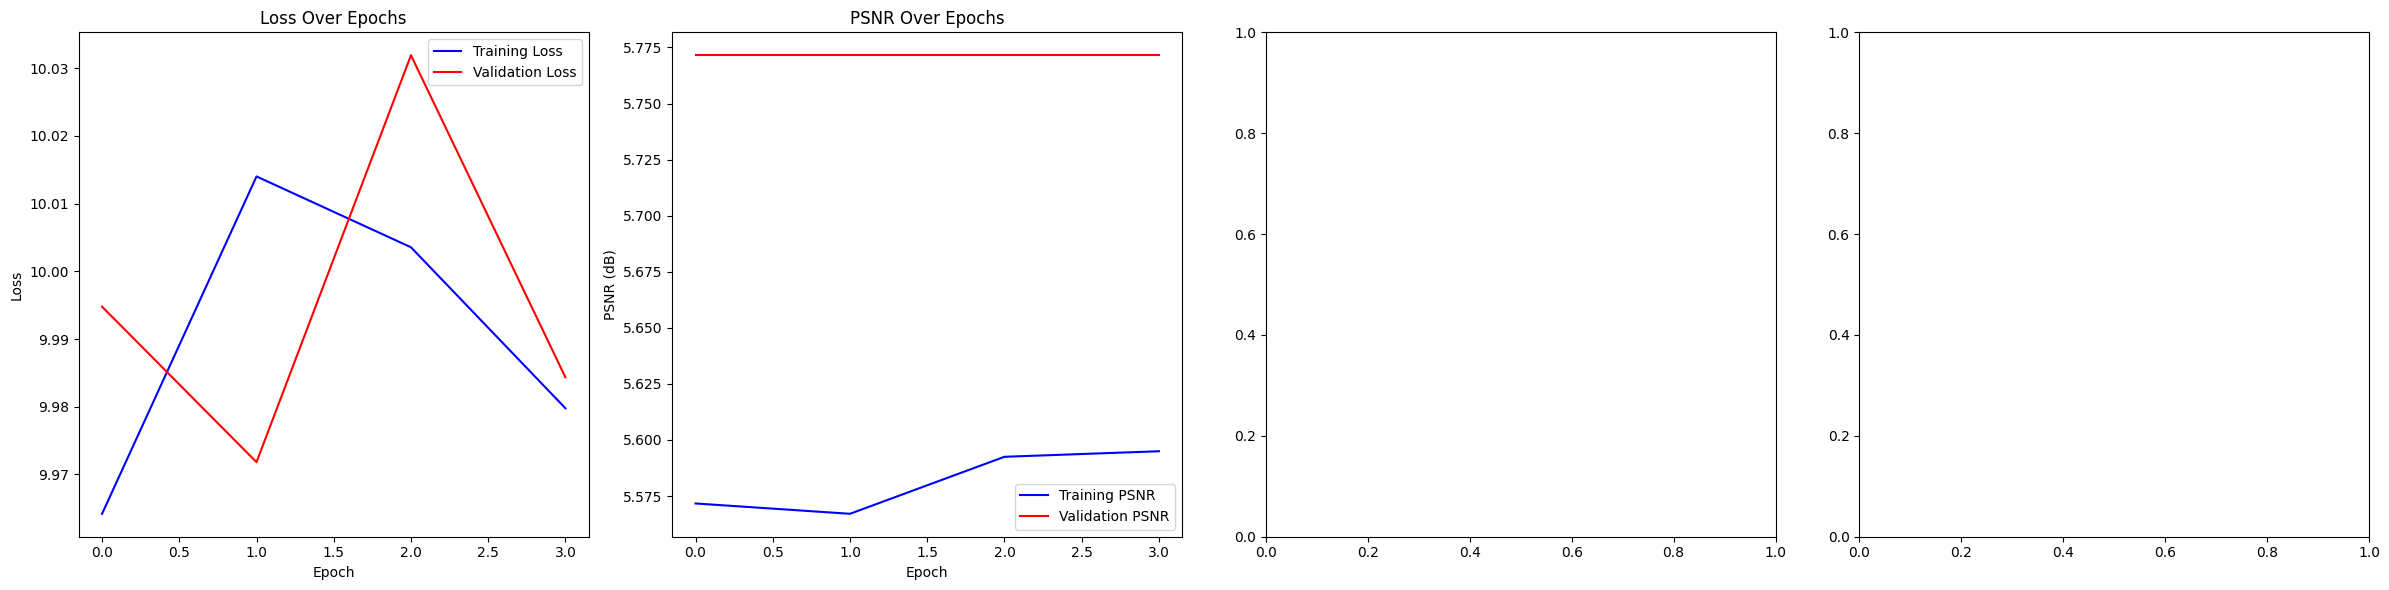

In [116]:
plot_loss_curves(model_results)